In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import Levenshtein as lev
import itertools

In [2]:
cc_names = pd.read_excel("../data/gene_names_with_location_and_pmvs.xlsx")
cc_names = cc_names.rename(columns = {"gene" : "Gene", "start" : "Start", "end" : "End"})
known_ADs = pd.read_csv("../output/known_ADs_considering_isoforms_and_canonical.csv")
cc_names = pd.merge(known_ADs[["uniprotID", "Gene", "Start", "End"]], cc_names)
ensts = pd.read_csv("../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)
cc_names = pd.merge(cc_names, ensts)
cc_names["ENST"] = cc_names["ENST"].str.split(".").str[0]
cc_names["len"] = cc_names["End"] - cc_names["Start"] + 1
cc_names = cc_names.rename(columns = {"Start" : "start", "End" : "end"})
cc_names

,uniprotID,Gene,start,end,pMVS #,Gene Name,ENST,len
0,O94983,CAMTA2,285,468,404,CAMTA2_AD1,ENST00000348066,184
1,O94983,CAMTA2,472,581,405,CAMTA2_AD2,ENST00000348066,110
2,P11308,ERG,433,479,400,ERG_AD1,ENST00000288319,47
3,P11308,ERG,118,261,406,ERG_AD2,ENST00000288319,144
4,Q13422,IKZF1,284,365,402,IKZF1_AD,ENST00000331340,82
5,O14770,MEIS2,340,477,377,MEIS2_AD,ENST00000561208,138
6,Q15788,NCOA1,1241,1385,379,NCOA1_AD2,ENST00000348332,145
7,Q15788,NCOA1,840,1011,380,NCOA1_AD3,ENST00000348332,172
8,O95096,NKX2-2,220,273,381,NKX2-2_AD,ENST00000377142,54
9,P43354,NR4A2,1,91,382,NR4A2_AD1,ENST00000339562,91


In [3]:
# Loading in all variants
# am_bottom_10 = pd.read_csv("../output/caitlin_experiment/am_bottom10_vars.csv", index_col = 0)
# am_top_10 = pd.read_csv("../output/caitlin_experiment/am_top10_vars.csv", index_col = 0)
clinvar = pd.read_csv("../output/caitlin_experiment/clinvar_vars.csv", index_col = 0)
clinvar["list"] = "ClinVar"
cosmic = pd.read_csv("../output/caitlin_experiment/cosmic_vars.csv", index_col = 0)
cosmic["list"] = "COSMIC"
SPARK = pd.read_csv("../output/caitlin_experiment/patient_vars.csv", index_col = 0)
SPARK["list"] = "SPARK"
gnomad = pd.read_csv("../output/caitlin_experiment/gnomad_vars.csv", index_col = 0)


In [4]:
pt_vars = pd.concat([clinvar, cosmic, SPARK])
pt_vars["pos"] = pt_vars["Protein Change"].str.extract(r'(\d+)').astype(int)
gnomad["pos"] = gnomad["Protein Change"].str.extract(r'(\d+)').astype(int)
pt_vars

,Gene Name,Mutant Sequence,Protein Change,Mutation,list,pos
0,NKX2-2_AD,AQDLAAATFQAGIPFSAYSAQSLQYMQYNAQYSSASTPQYPTAHPL...,p.His244Tyr,clinvar,ClinVar,244
1,NKX2-2_AD,AQDLAAATFQAGIPFSAYSVQSLQHMQYNAQYSSASTPQYPTAHPL...,p.Ala239Val,clinvar,ClinVar,239
2,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Ser,clinvar,ClinVar,226
3,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Arg,clinvar,ClinVar,226
4,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Cys,clinvar,ClinVar,226
...,...,...,...,...,...,...
550,PAX5_AD,GRDLASTTLPRYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Gly314Arg,patient,SPARK,314
551,PAX5_AD,GRDLASMTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Thr310Met,patient,SPARK,310
552,PAX5_AD,GRDLASATLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Thr310Ala,patient,SPARK,310
553,PAX5_AD,GRDLVSTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Ala308Val,patient,SPARK,308


In [5]:
AD = "OTX1_AD"
AD_pt_vars = pt_vars[pt_vars["Gene Name"]  == AD]
AD_pt_vars

,Gene Name,Mutant Sequence,Protein Change,Mutation,list,pos
2,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Ser,clinvar,ClinVar,226
3,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Arg,clinvar,ClinVar,226
4,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Cys,clinvar,ClinVar,226
454,OTX1_AD,AASSIWSQASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Pro179Gln,cosmic,COSMIC,179
455,OTX1_AD,AASSIWSLASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Pro179Leu,cosmic,COSMIC,179
...,...,...,...,...,...,...
185,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Pro338His,patient,SPARK,338
186,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Cys340Ser,patient,SPARK,340
187,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Lys344Asn,patient,SPARK,344
188,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Ala347Ser,patient,SPARK,347


In [6]:
AD_gnomad = gnomad[gnomad["Gene Name"] == AD]
AD_gnomad

,Gene Name,Mutant Sequence,Protein Change,Mutation,pos
395,OTX1_AD,GASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Ala172Gly,gnomad,172
396,OTX1_AD,AVSSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Ala173Val,gnomad,173
397,OTX1_AD,AAPSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Ser174Pro,gnomad,174
398,OTX1_AD,AALSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Ser174Leu,gnomad,174
399,OTX1_AD,AASAIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Ser175Ala,gnomad,175
...,...,...,...,...,...
630,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gln352His,gnomad,352
631,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Val353Ile,gnomad,353
632,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Val353Leu,gnomad,353
633,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Leu354Ser,gnomad,354


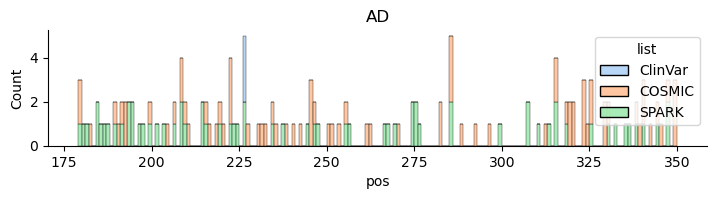

In [97]:
plt.figure(figsize = (8.5, 1.5))

min_pos = min(AD_pt_vars["pos"])
max_pos = max(AD_pt_vars["pos"])

sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
             x="pos", kde=False,
             palette="pastel", hue="list",
             element="bars", legend=True, bins = np.arange(min_pos, max_pos + 1, 1))

plt.title("AD")
sns.despine()

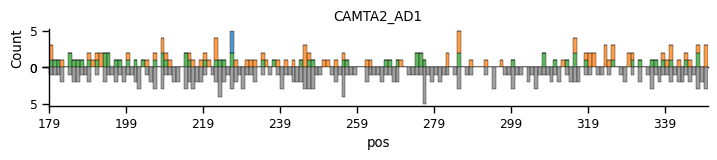

In [300]:
# Create a figure with two subplots (top and bottom) sharing the x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8.5,1), sharex=True)

# Create the top plot (original histogram)
min_pos = min(AD_pt_vars["pos"])
max_pos = max(AD_pt_vars["pos"])

sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
             x="pos", kde=False, 
             hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)

# Add title to the top plot
ax1.set_title(AD)
sns.despine(ax=ax1)

sns.histplot(data=AD_gnomad, stat="count", multiple="stack",
             x="pos", kde=False, color = "gray",
             element="bars", legend=True, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)

ax1_ymin, ax_1ymax = ax1.get_ylim()
ax2_ymin, ax_2ymax = ax2.get_ylim()
ymin, ymax = min(ax1_ymin, ax2_ymin), max(ax_1ymax, ax_2ymax)

ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

# Invert the y-axis for the bottom plot
ax2.invert_yaxis()
ax2.set_ylabel("")
ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
ax2.set_xlim(min_pos, max_pos)
    
# Add title to the bottom plot
sns.despine()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()


In [301]:
sns.color_palette("magma")


[(0.135053, 0.068391, 0.315),
 (0.372116, 0.092816, 0.499053),
 (0.594508, 0.175701, 0.501241),
 (0.828886, 0.262229, 0.430644),
 (0.973381, 0.46152, 0.361965),
 (0.997341, 0.733545, 0.505167)]

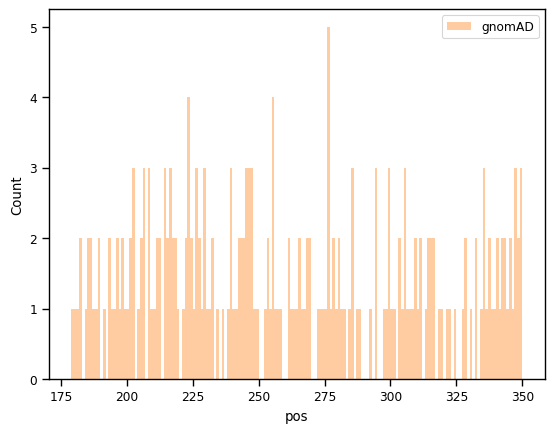

In [302]:
sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = sns.color_palette("magma")[5], edgecolor = "none", label = "gnomAD",
                 element="bars", legend=True, bins=np.arange(min_pos, max_pos + 1, 1))
plt.legend()

In [303]:
AD_pt_vars["list"].value_counts()

list
COSMIC     79
SPARK      67
ClinVar     3
Name: count, dtype: int64

In [54]:
palette = sns.color_palette("plasma", 4)
color_palette = {"SPARK": palette[0],
                 "COSMIC": palette[1],
                 "ClinVar": palette[2],
                 "gnomAD": palette[3]}

# color_palette = {"SPARK": "#FFB30F",
#                  "COSMIC": "#750D37",
#                  "ClinVar": "#01295F",
#                  "gnomAD": "#849324"}

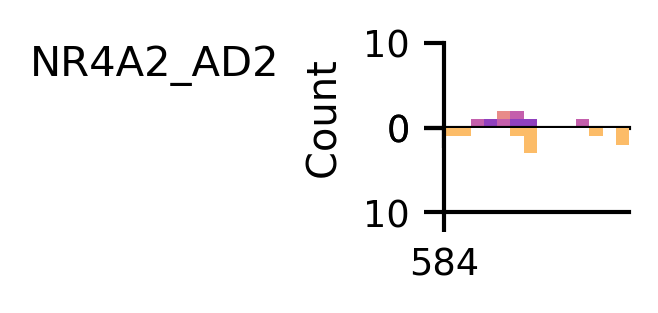

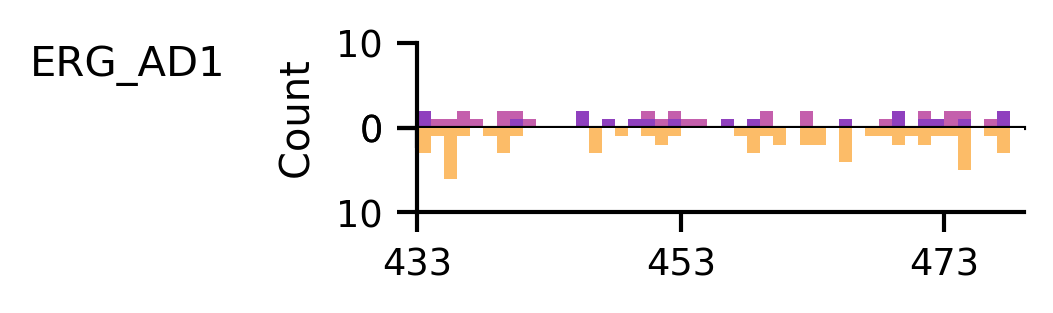

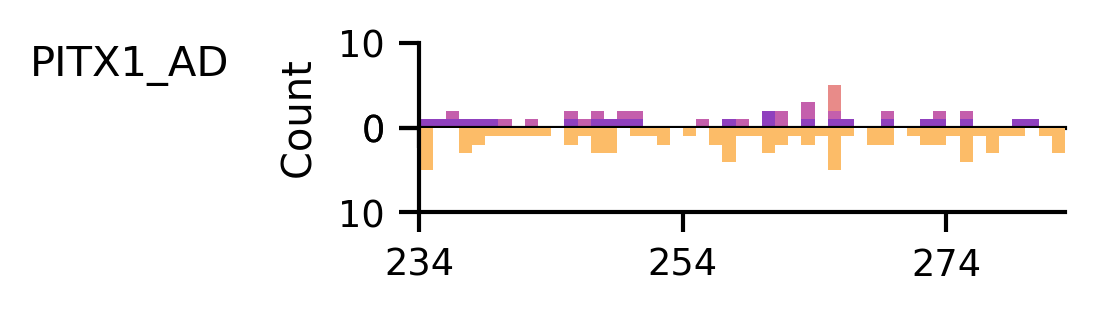

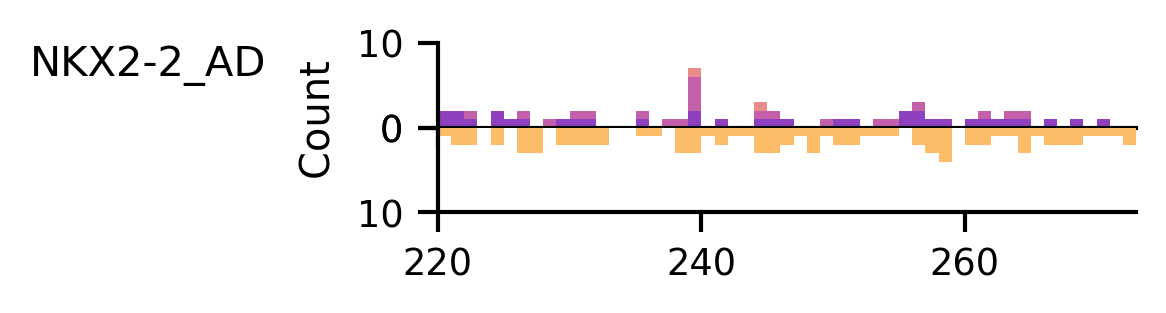

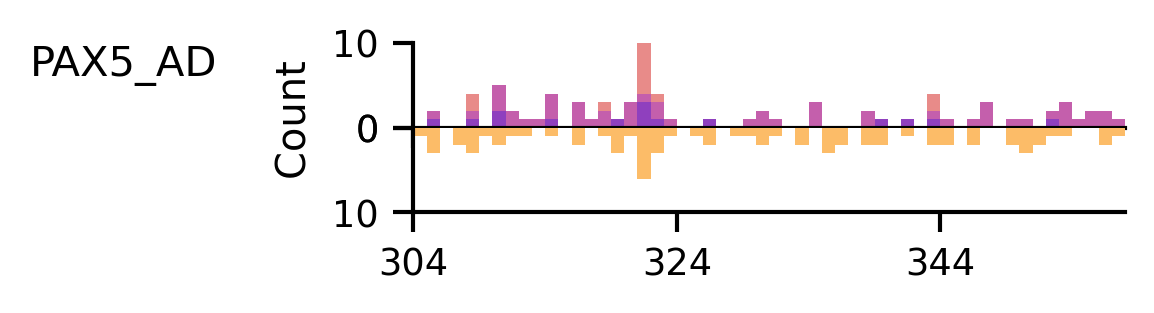

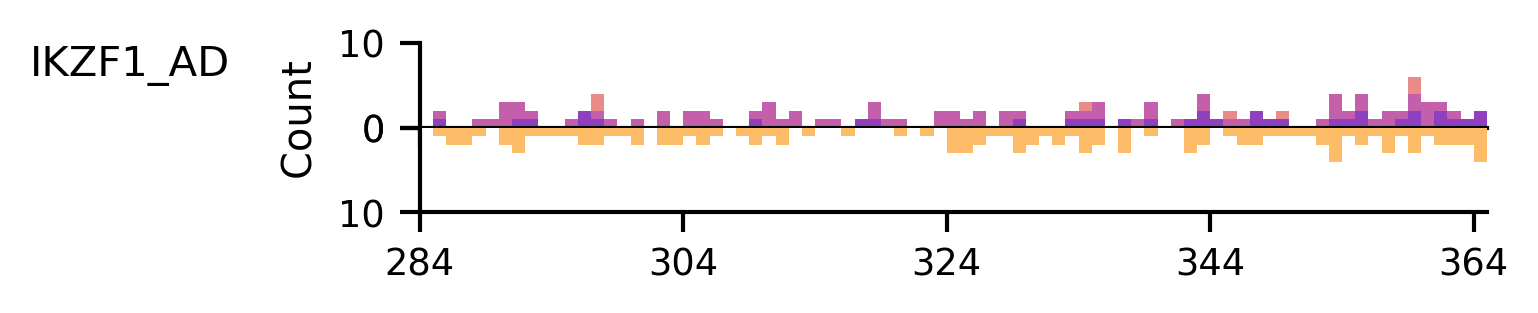

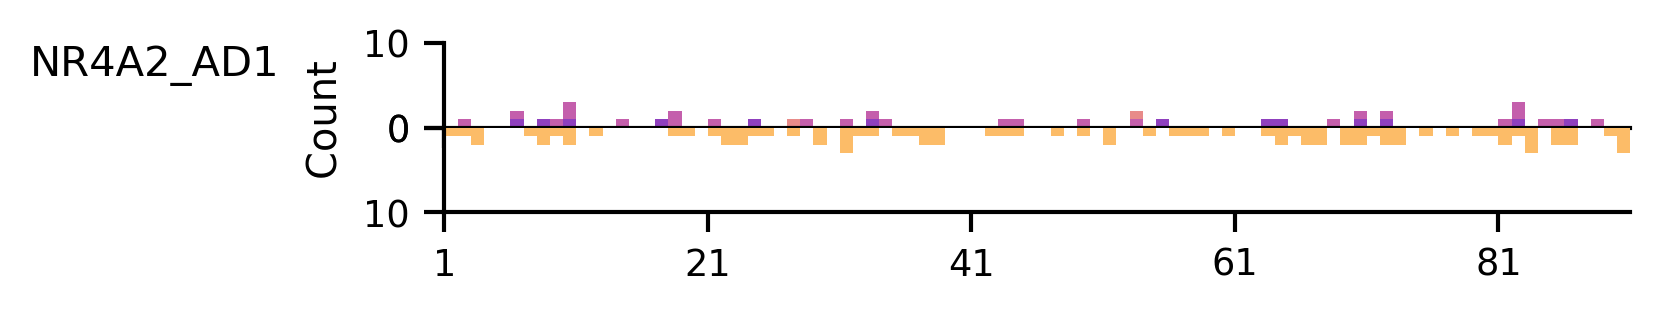

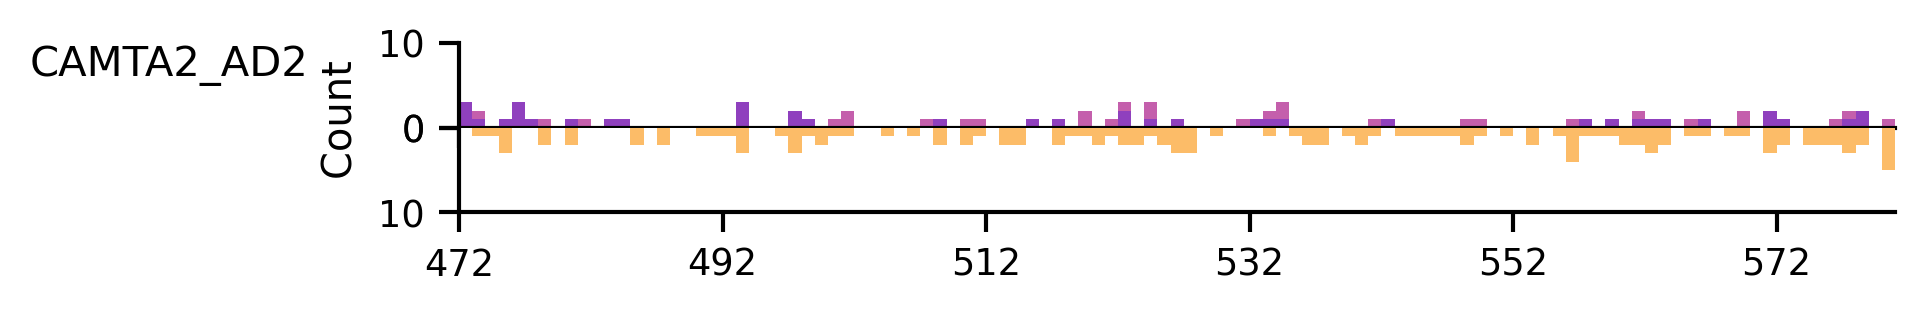

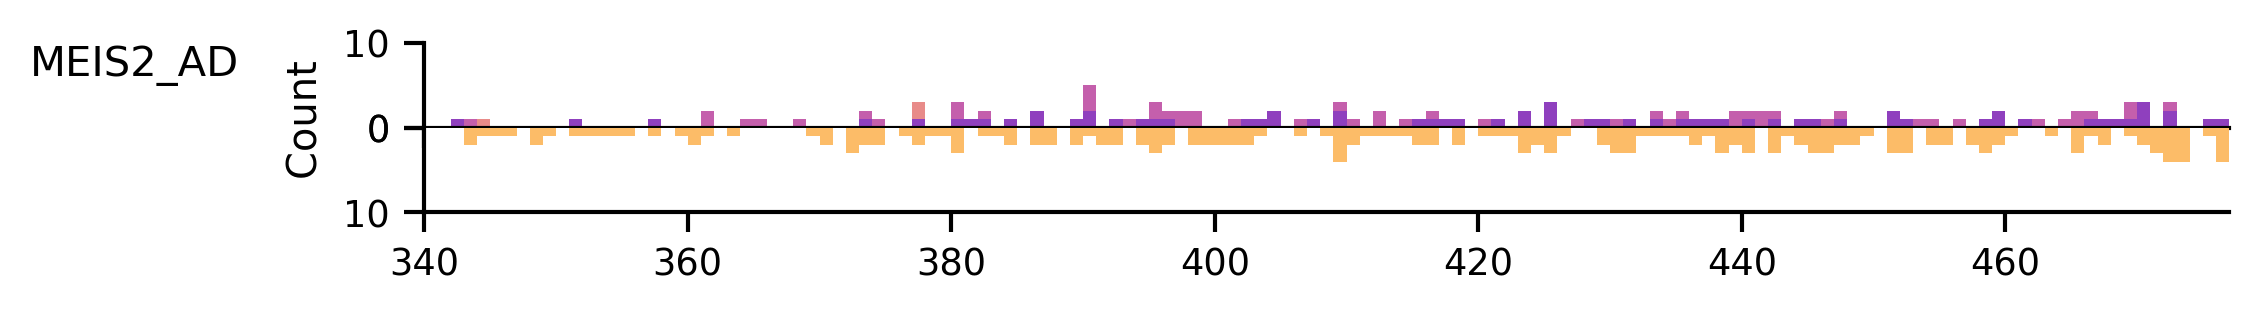

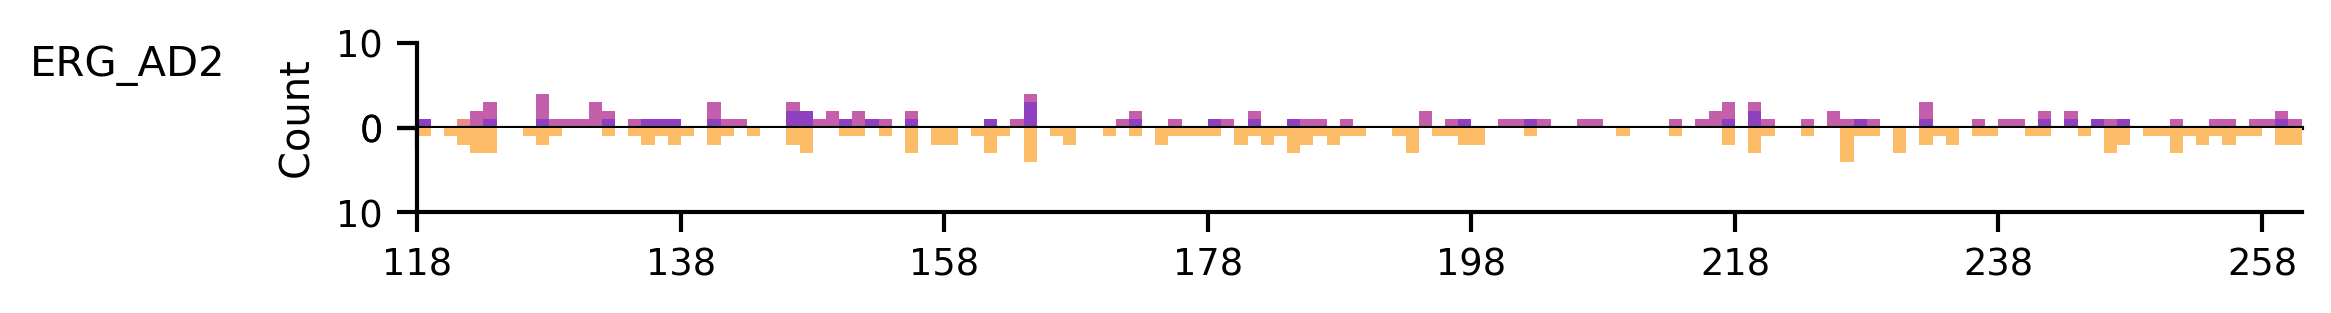

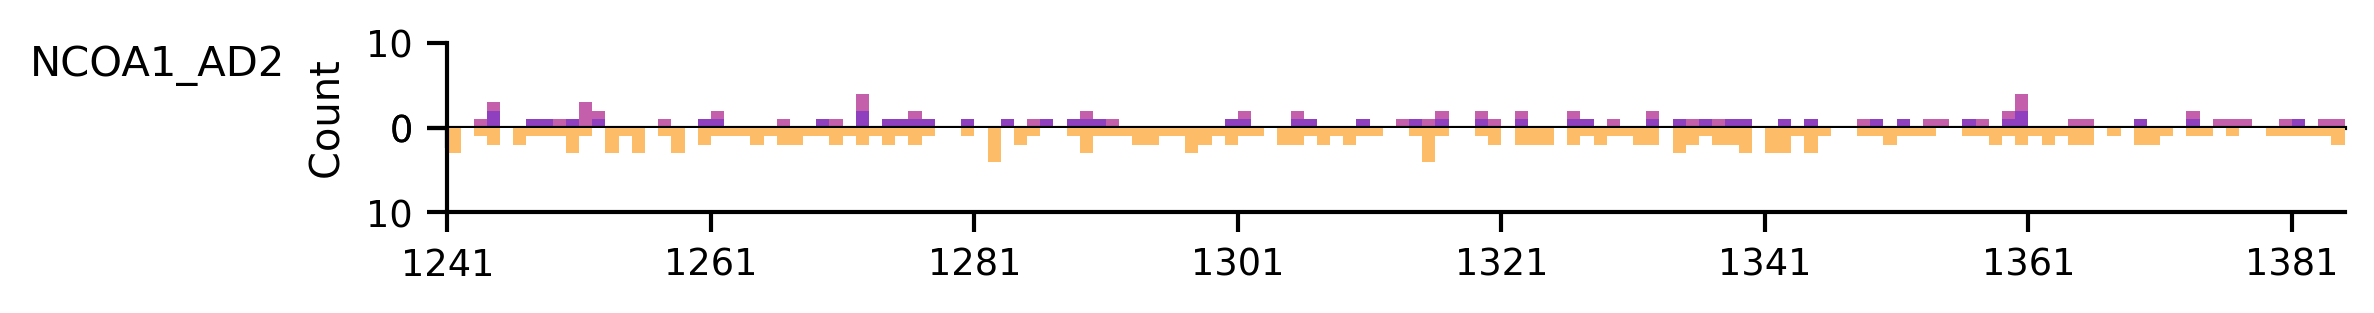

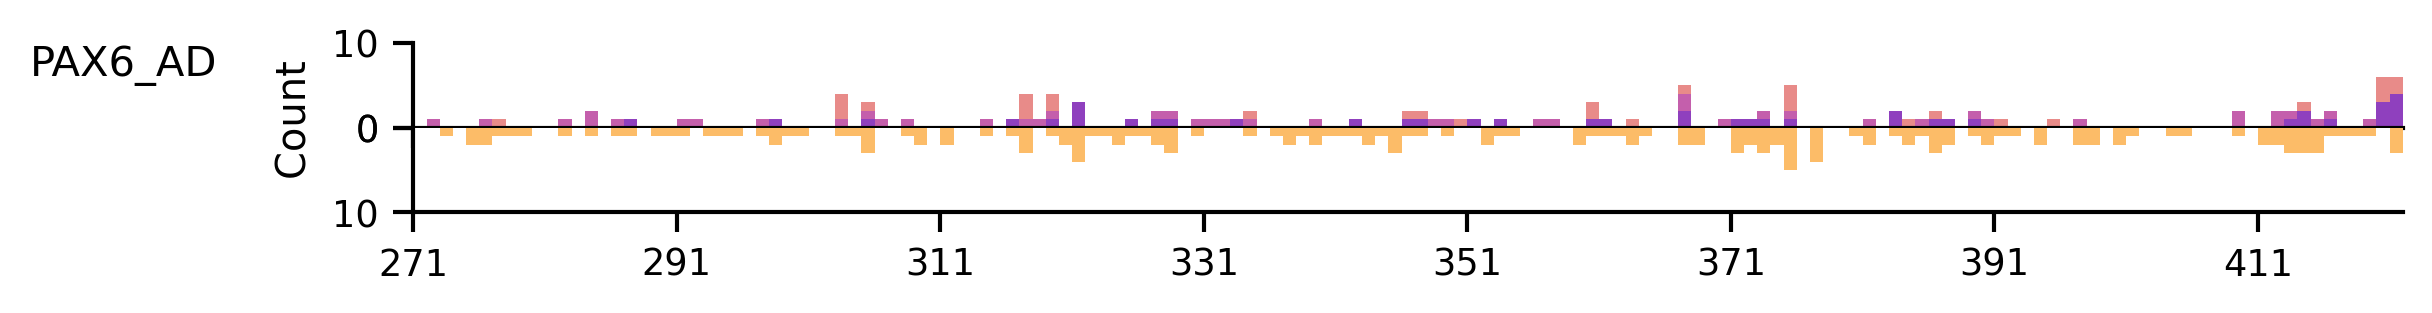

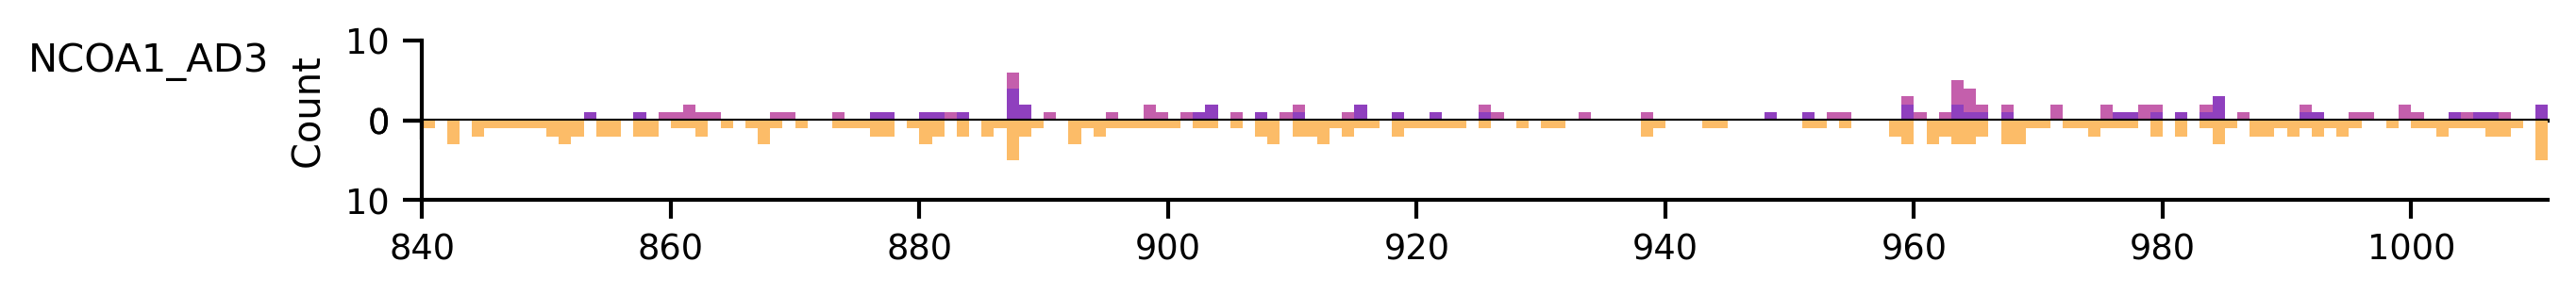

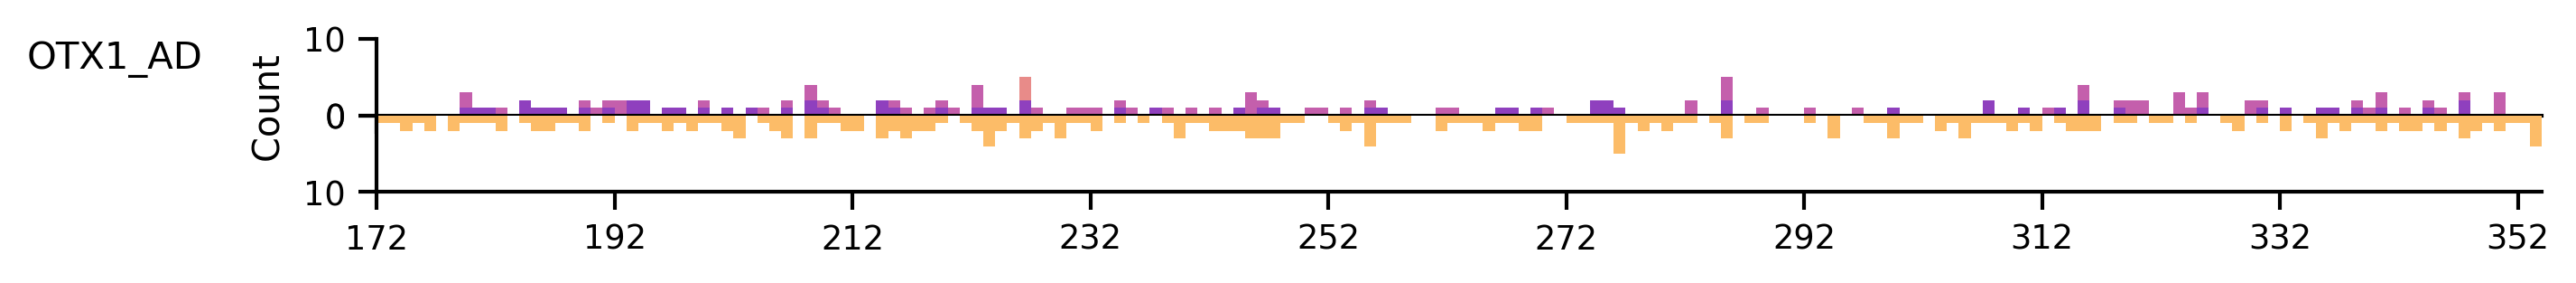

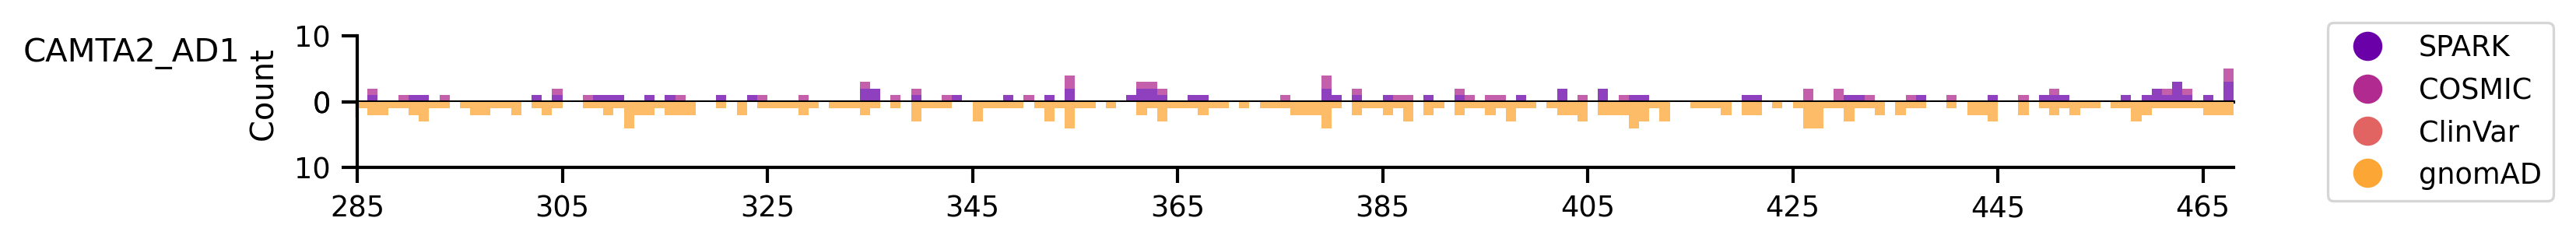

In [55]:
from matplotlib.backends.backend_pdf import PdfPages

sns.set_context('paper')

def plot_one_AD_track(AD):
    AD_pt_vars = pt_vars[pt_vars["Gene Name"]  == AD]
    AD_gnomad = gnomad[gnomad["Gene Name"] == AD]

     # Create the top plot (original histogram)
    min_pos = cc_names[cc_names["Gene Name"] == AD]["start"].iloc[0]
    max_pos =cc_names[cc_names["Gene Name"] == AD]["end"].iloc[0]
    
    # Create a figure with two subplots (top and bottom) sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8.5 * (max_pos - min_pos) / 150, 11/15), sharex=True, dpi = 300)
    

    sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
                 x="pos", kde=False, edgecolor = "none", palette = color_palette,
                 hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)
    
    # Add title to the top plot
    ax1.set_ylabel(AD, rotation=0, labelpad=50, fontsize=10)  # Gene name on the left
    sns.despine(ax=ax1)
    
    sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = color_palette["gnomAD"], edgecolor = "none", label = "gnomAD",
                 element="bars", bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)

    # ax1_ymin, ax_1ymax = ax1.get_ylim()
    # ax2_ymin, ax_2ymax = ax2.get_ylim()
    #ymin, ymax = min(ax1_ymin, ax2_ymin), max(ax_1ymax, ax_2ymax)
    ymin, ymax = 0, 10
    
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    
    # Invert the y-axis for the bottom plot
    ax2.invert_yaxis()
    ax2.set_ylabel("        Count")
    ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
    ax2.set_xlim(min_pos, max_pos)
    ax2.set_xlabel("")

    
    # Add title to the bottom plot
    sns.despine()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

    

cc_names = cc_names.sort_values(by = "len", ascending = True)

# with PdfPages('AD_tracks.pdf') as pdf:

for AD in cc_names["Gene Name"]:
    plot_one_AD_track(AD)

# Manually create the legend
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["SPARK"], markersize=10, label="SPARK"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["COSMIC"], markersize=10, label="COSMIC"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["ClinVar"], markersize=10, label="ClinVar"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["gnomAD"], markersize=10, label="gnomAD")
]

# Add the legend to the plot
plt.legend(handles=legend_labels, loc = (1.05 ,-0.5))

# Show the plot
plt.show()

TO-DO 
- [DONE] Make colors consistent between plots
- [DONE] Make sure colors are color blind friendly
- Make into subplots
- Make y-axis scales consistent?

In [56]:
import matplotlib.gridspec as gridspec


In [57]:
cc_names[cc_names["Gene Name"] == AD]["len"].iloc[0]

184

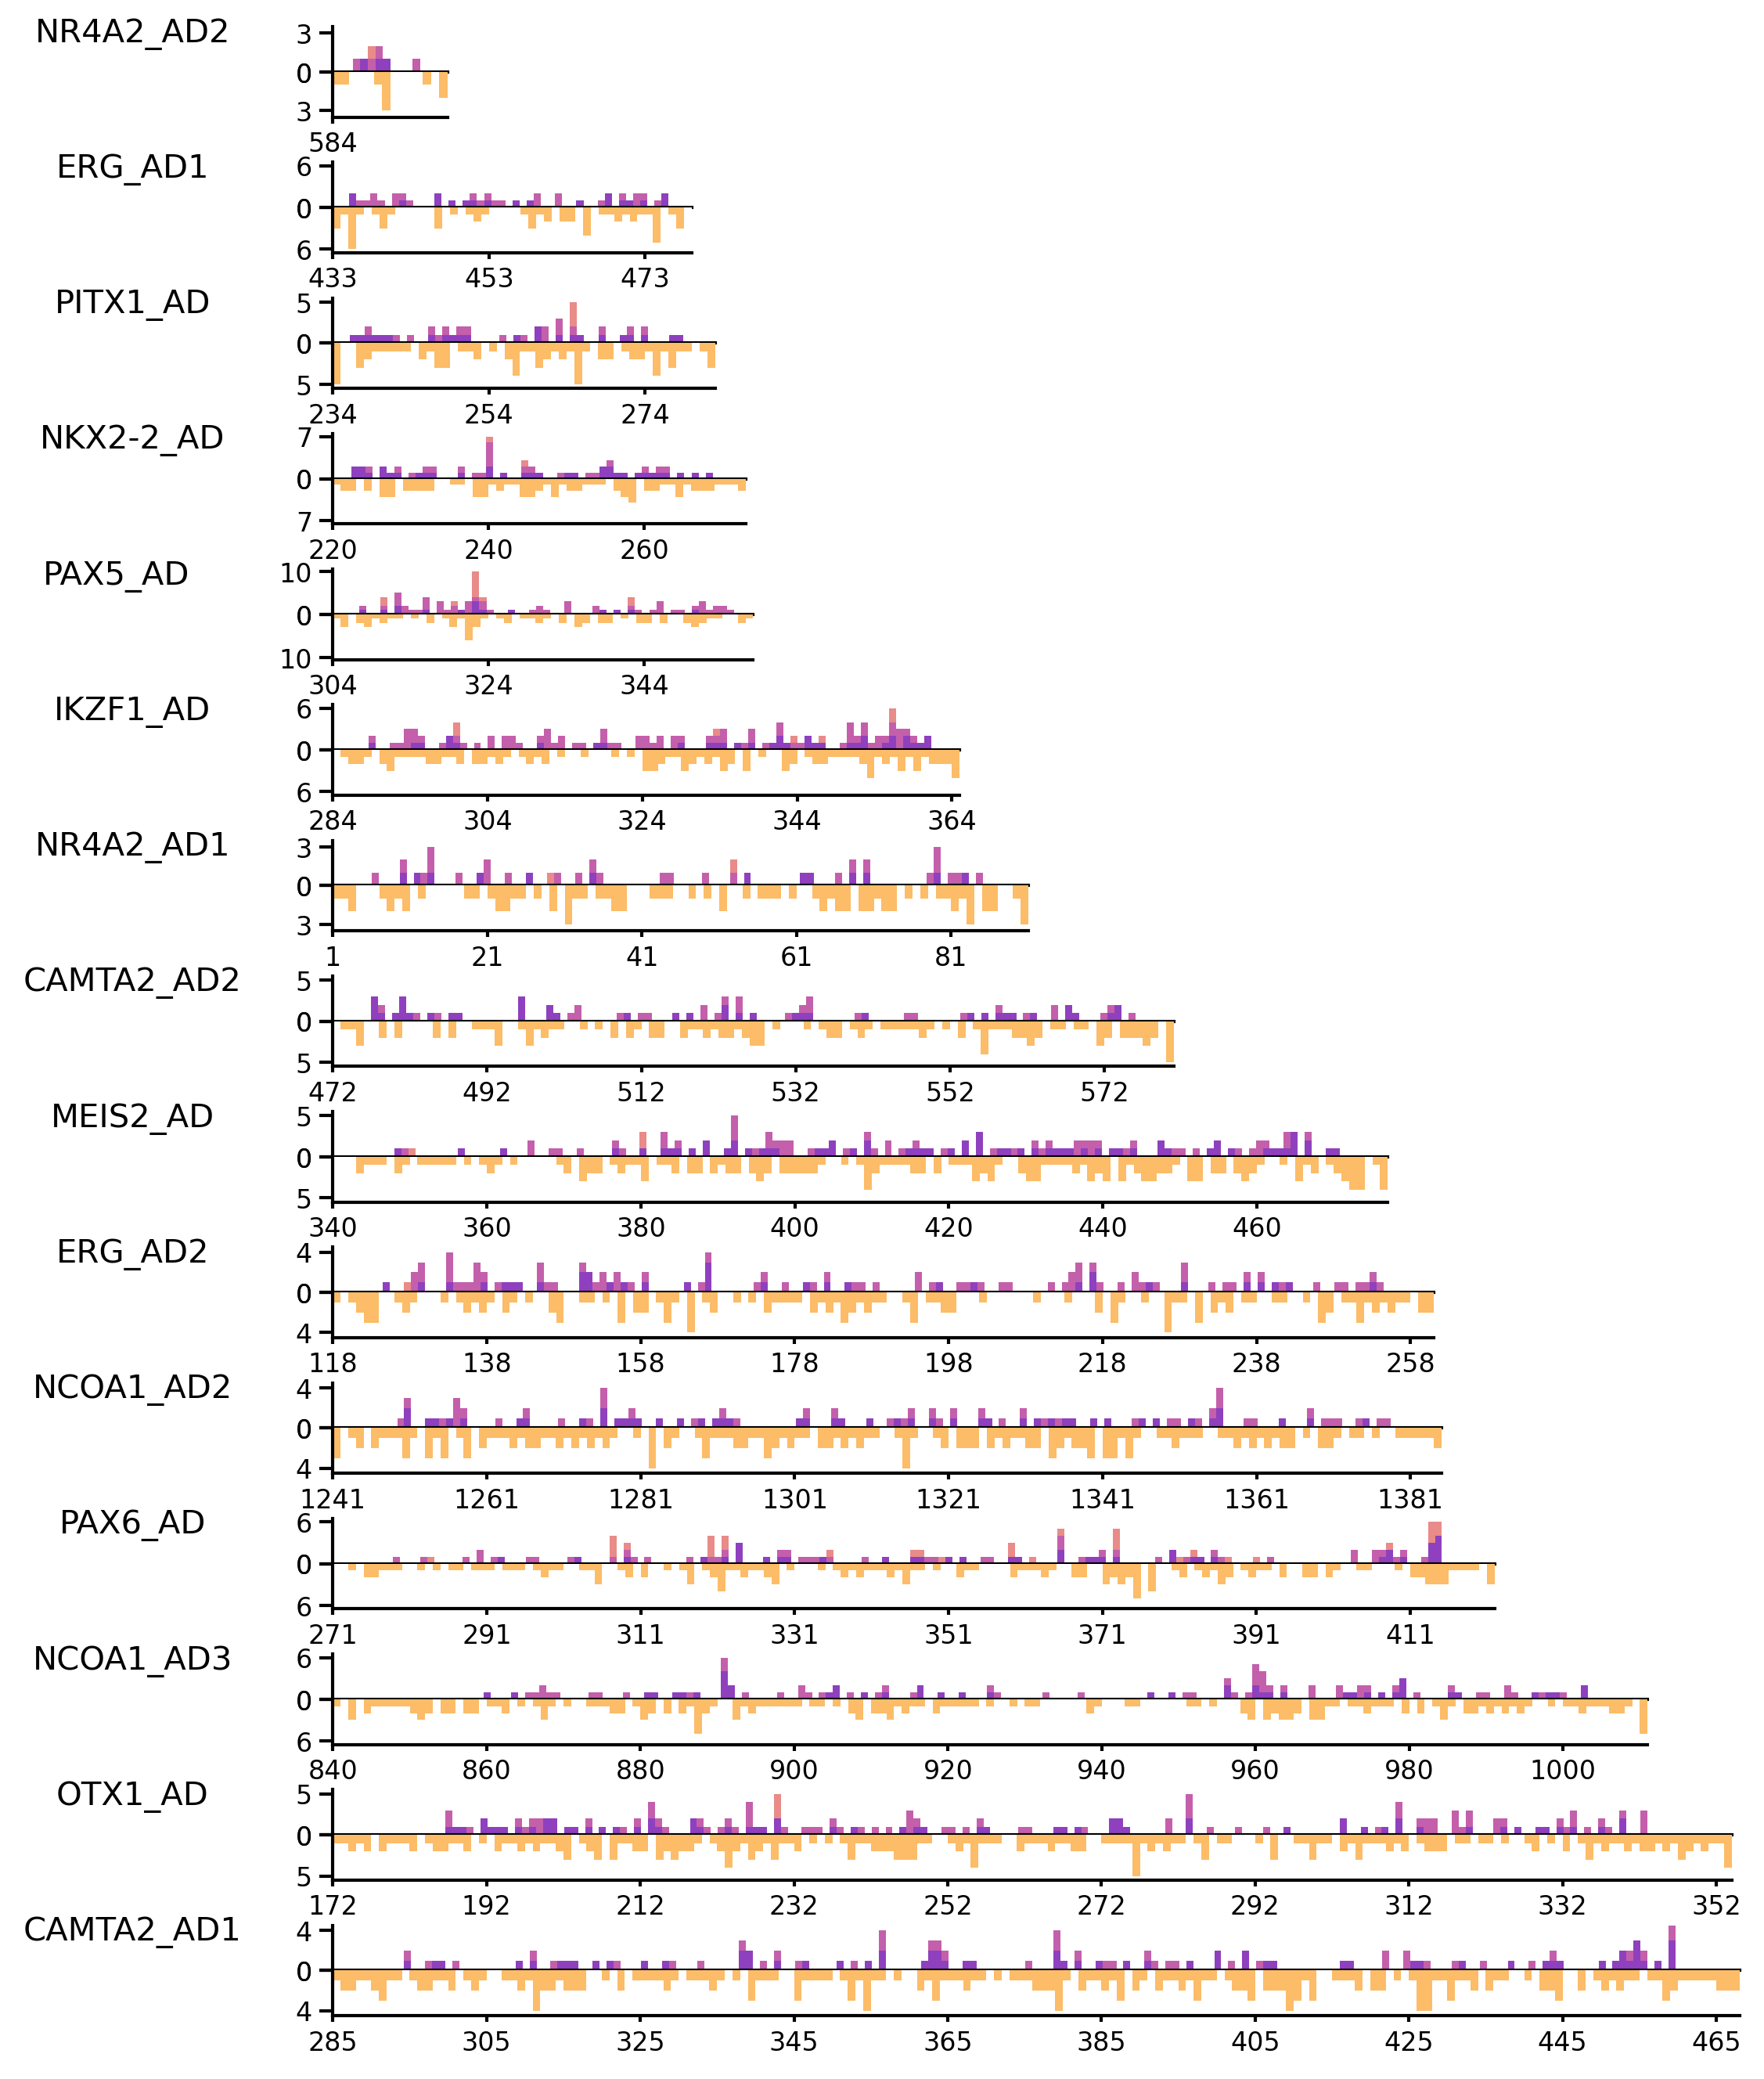

In [61]:
# Making with subplots


fig = plt.figure(figsize=(8.5, 11), dpi = 300)
outer = gridspec.GridSpec(15, 1, hspace=0.5)

def plot_one_AD_track_subplots(AD, i):

    min_pos = cc_names[cc_names["Gene Name"] == AD]["start"].iloc[0]
    max_pos =cc_names[cc_names["Gene Name"] == AD]["end"].iloc[0]

    # Getting the disease-associated and neutral variants
    AD_pt_vars = pt_vars[pt_vars["Gene Name"]  == AD]
    AD_gnomad = gnomad[gnomad["Gene Name"] == AD]
    
    #Setting up the ax
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[i], wspace = 0, hspace = 0)

    num_positions = cc_names[cc_names["Gene Name"] == AD]["len"].iloc[0]
    width_ratio = num_positions / (len(all_muts) / 15)  # Normalize the width
    width = max(0, min(1.5, width_ratio))  # Limit width between 0.25 and 1.5

    # Plotting of ax1
    ax1 = fig.add_subplot(inner[0])
    curr_ax1_pos = ax1.get_position()    

    ax1.set_position([curr_ax1_pos.x0, curr_ax1_pos.y0, width, curr_ax1_pos.height])
    
    sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
                 x="pos", kde=False, edgecolor = "none", palette = color_palette,
                 hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)

    # Plotting of ax2
    ax2 = fig.add_subplot(inner[1])
    curr_ax2_pos = ax2.get_position()    
    ax2.set_position([curr_ax2_pos.x0, curr_ax2_pos.y0, width, curr_ax2_pos.height])

    sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = color_palette["gnomAD"], edgecolor = "none", label = "gnomAD",
                 element="bars", bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)
    

    #ymin, ymax = 0, 10
    extrema = max(max(AD_pt_vars["pos"].value_counts()), max(AD_gnomad["pos"].value_counts())) 
    ymin, ymax = 0, extrema
    
    ax1.set_ylim(ymin, ymax + 0.5)
    ax2.set_ylim(ymin, ymax + 0.5)

    ax1.set_yticks([0, ymax])
    ax1.set_yticklabels([0, ymax], fontsize=8)  # Smaller font size for x-tick labels
    ax1.tick_params(axis='y', which='major', pad=2.3, length = 4)

    ax2.set_yticks([0, ymax])
    ax2.set_yticklabels([0, ymax], fontsize=8)  # Smaller font size for x-tick labels
    ax2.tick_params(axis='y', which='major', pad=2.3, length = 4)



    # Invert the y-axis for the bottom plot
    ax2.invert_yaxis()

    ax1.set_xticks([])
    
    ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
    ax2.set_xticklabels(np.arange(min_pos, max_pos + 1, 20), fontsize=8)  # Smaller font size for x-tick labels
    ax2.tick_params(axis='x', which='major', pad=2.3, length = 2)

   
    ax2.set_xlim(min_pos, max_pos)
    ax2.set_xlabel("")
    ax1.set_xlabel("")

    ax1.set_ylabel("")
    ax2.set_ylabel("")

    ax1.set_ylabel(AD, rotation=0, labelpad=50, fontsize=10)  # Gene name on the left

    sns.despine(ax = ax1)
    sns.despine(ax = ax2)


first = True

for i, AD in enumerate(cc_names["Gene Name"]):
    plot_one_AD_track_subplots(AD, i)
    if first:
        first = True

fig.show()

In [67]:
unique_pt_vars = pt_vars[~pt_vars["Mutant Sequence"].isin(gnomad["Mutant Sequence"])]
unique_pt_vars

,Gene Name,Mutant Sequence,Protein Change,Mutation,list,pos
5,PITX1_AD,VPGMPNSGLNNINNLTGSSLNSAMSPGACPYCTPASPYSVYRDTCN...,p.Gly265Cys,clinvar,ClinVar,265
8,NR4A2_AD1,MPCVQAQYGSSPQGASPASQSYSYHSSGEYSSDFLTPEFVKFSMDL...,p.Ala53Val,clinvar,ClinVar,53
9,NR4A2_AD1,MPCVQAQYGSSPQGASPASQSYSYHSPGEYSSDFLTPEFVKFSMDL...,p.Ser27Pro,clinvar,ClinVar,27
10,NR4A2_AD2,PPAIMDKLFLDTLPF,p.Ile588Met,clinvar,ClinVar,588
13,IKZF1_AD,GDKGLSDTPYDSSASYEKENEMMKSHVMDQAINNAINYLGAESLRP...,p.Pro334Leu,clinvar,ClinVar,334
...,...,...,...,...,...,...
534,ERG_AD1,PHPPALPVTSSSFFGAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Ala447Gly,patient,SPARK,447
535,ERG_AD1,PHPPALPVTSSSLFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Phe445Leu,patient,SPARK,445
536,ERG_AD1,PHPPALPVTSSSIFAAPNPYWNSPTGGIYPNTRLPTSHMPSHLGTYY,p.Phe445Ile,patient,SPARK,445
540,PAX5_AD,GRDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Ser352Pro,patient,SPARK,352


In [69]:
# Repeating plotting with gnomad subtracted from numerator

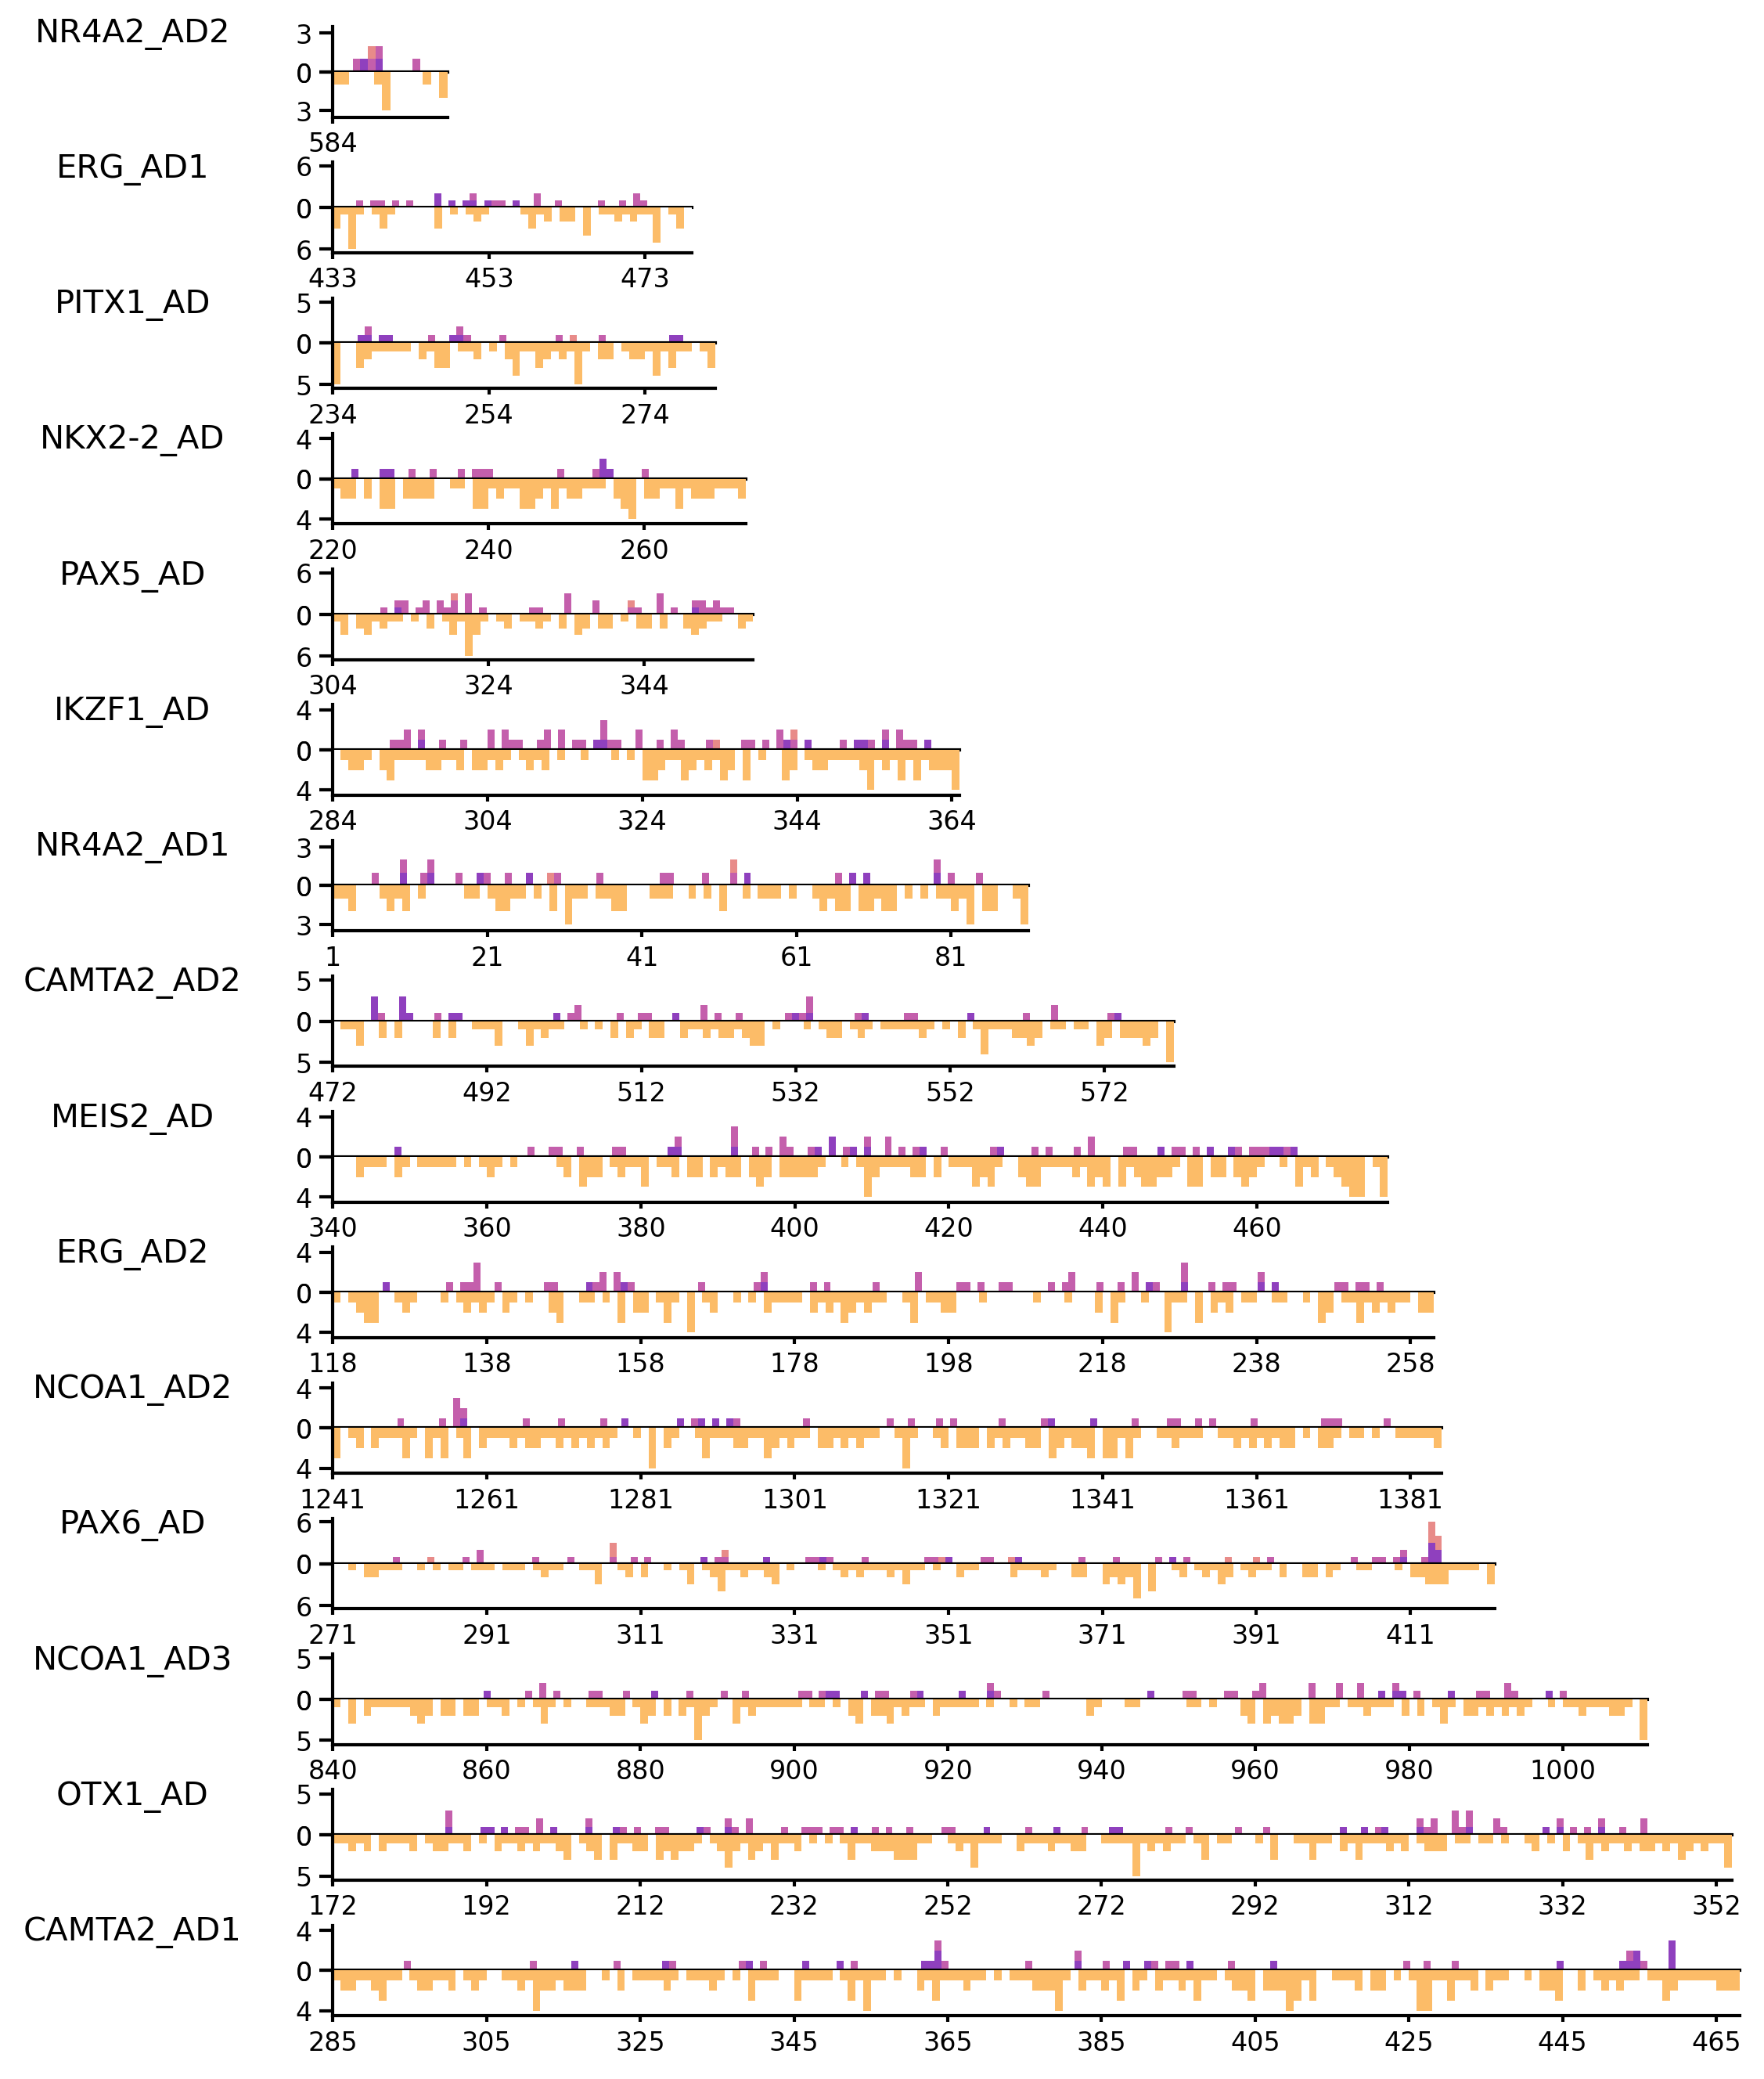

In [70]:
# Making with subplots


fig = plt.figure(figsize=(8.5, 11), dpi = 300)
outer = gridspec.GridSpec(15, 1, hspace=0.5)

def plot_one_AD_track_subplots(AD, i):

    min_pos = cc_names[cc_names["Gene Name"] == AD]["start"].iloc[0]
    max_pos =cc_names[cc_names["Gene Name"] == AD]["end"].iloc[0]

    # Getting the disease-associated and neutral variants
    AD_pt_vars = unique_pt_vars[unique_pt_vars["Gene Name"]  == AD]
    AD_gnomad = gnomad[gnomad["Gene Name"] == AD]
    
    #Setting up the ax
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[i], wspace = 0, hspace = 0)

    num_positions = cc_names[cc_names["Gene Name"] == AD]["len"].iloc[0]
    width_ratio = num_positions / (len(all_muts) / 15)  # Normalize the width
    width = max(0, min(1.5, width_ratio))  # Limit width between 0.25 and 1.5

    # Plotting of ax1
    ax1 = fig.add_subplot(inner[0])
    curr_ax1_pos = ax1.get_position()    

    ax1.set_position([curr_ax1_pos.x0, curr_ax1_pos.y0, width, curr_ax1_pos.height])
    
    sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
                 x="pos", kde=False, edgecolor = "none", palette = color_palette,
                 hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)

    # Plotting of ax2
    ax2 = fig.add_subplot(inner[1])
    curr_ax2_pos = ax2.get_position()    
    ax2.set_position([curr_ax2_pos.x0, curr_ax2_pos.y0, width, curr_ax2_pos.height])

    sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = color_palette["gnomAD"], edgecolor = "none", label = "gnomAD",
                 element="bars", bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)
    

    #ymin, ymax = 0, 10
    extrema = max(max(AD_pt_vars["pos"].value_counts()), max(AD_gnomad["pos"].value_counts())) 
    ymin, ymax = 0, extrema
    
    ax1.set_ylim(ymin, ymax + 0.5)
    ax2.set_ylim(ymin, ymax + 0.5)

    ax1.set_yticks([0, ymax])
    ax1.set_yticklabels([0, ymax], fontsize=8)  # Smaller font size for x-tick labels
    ax1.tick_params(axis='y', which='major', pad=2.3, length = 4)

    ax2.set_yticks([0, ymax])
    ax2.set_yticklabels([0, ymax], fontsize=8)  # Smaller font size for x-tick labels
    ax2.tick_params(axis='y', which='major', pad=2.3, length = 4)



    # Invert the y-axis for the bottom plot
    ax2.invert_yaxis()

    ax1.set_xticks([])
    
    ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
    ax2.set_xticklabels(np.arange(min_pos, max_pos + 1, 20), fontsize=8)  # Smaller font size for x-tick labels
    ax2.tick_params(axis='x', which='major', pad=2.3, length = 2)

   
    ax2.set_xlim(min_pos, max_pos)
    ax2.set_xlabel("")
    ax1.set_xlabel("")

    ax1.set_ylabel("")
    ax2.set_ylabel("")

    ax1.set_ylabel(AD, rotation=0, labelpad=50, fontsize=10)  # Gene name on the left

    sns.despine(ax = ax1)
    sns.despine(ax = ax2)


first = True

for i, AD in enumerate(cc_names["Gene Name"]):
    plot_one_AD_track_subplots(AD, i)
    if first:
        first = True

fig.show()

In [62]:
# Adding conservation
from statsmodels.nonparametric.smoothers_lowess import lowess

tfs_tbl = pd.read_csv("../soto_analysis/outputs/TFs_table_proteins.txt", sep = "\t")


def plot_ENST_trace(ENST, start, end):
    #display(tfs_tbl[tfs_tbl["ENST"] == ENST])
    ENST_phylo_P = cds_phylo_P[cds_phylo_P["ENST"] == ENST]
    # If negative strand, sort ascending = False
    # Else, sort ascending = True
    if ENST_phylo_P[5].iloc[0] == "-":
        ascending = False
    else: 
        ascending = True
    ENST_phylo_P = ENST_phylo_P.sort_values(by = 1, ascending = ascending)
    uniprotID = cc_names[cc_names["ENST"] == ENST]["uniprotID"].iloc[0]
    #display(ENST_phylo_P)


    #ENST_phylo_P["cds_nt"] = np.arange(len(ENST_phylo_P))

    #ENST_phylo_P = ENST_phylo_P[(ENST_phylo_P["cds_nt"] > (start * 3)) & (ENST_phylo_P["cds_nt"] < (end * 3))]
    
    domains = pd.read_csv("../soto_analysis/outputs/mutations/domains_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
    domains = domains[[0, 1, 2, 3]]
    ENST_phylo_P_with_domains = pd.merge(ENST_phylo_P, domains, how = "left", on = [0, 1, 2])
    ENST_phylo_P_with_domains = ENST_phylo_P_with_domains.fillna(0)
    ENST_phylo_P_with_domains["cds_nt"] = np.arange(len(ENST_phylo_P_with_domains))

    

    smoothed = lowess(ENST_phylo_P_with_domains['PhyloP'], ENST_phylo_P_with_domains["cds_nt"], frac=0.0025)  # Adjust frac for smoothness
    color_map = {
        'AD': 'orange',
        'DBD': 'purple'
    }
    
    # Create a new DataFrame for smoothed data
    smoothed_df = pd.DataFrame(smoothed, columns=["cds_nt", 'smoothed'])
    smoothed_df = smoothed_df[(smoothed_df["cds_nt"] > (start * 3)) & (smoothed_df["cds_nt"] < (end * 3))]
    # display(smoothed_df)
    # print(start)
    # print(end)


    #sns.scatterplot(data=ENST_phylo_P_with_domains, x="cds_nt", y='PhyloP', color='black', alpha = 0.05, size = 20, legend = False)
    plt.legend().remove()

    # sns.lineplot(data=ENST_phylo_P, x="cds_nt", y='PhyloP', color='black')
    # plt.xlim(min(ENST_phylo_P["cds_nt"]), max(ENST_phylo_P["cds_nt"]) + 1)
    # extreme = max(np.abs(ENST_phylo_P["PhyloP"]))
    # plt.ylim(-1 * extreme - 0.1, extreme + 0.1)

    return np.array(smoothed_df["cds_nt"]) / 3, np.array(smoothed_df["smoothed"])

In [540]:
cds_phylo_P = []

for ENST in set(cc_names["ENST"]):
    df = pd.read_csv("../soto_analysis/outputs/mutations/cds_zoonomia_15/" + ENST + ".bed", sep = "\t", header = None)
    cds_phylo_P.append(df)

cds_phylo_P = pd.concat(cds_phylo_P)
cds_phylo_P = cds_phylo_P.rename(columns = {4: "ENST", 9: "PhyloP"})
cds_phylo_P

,0,1,2,3,ENST,5,6,7,8,PhyloP
0,17,4968755,4968756,O94983,ENST00000348066,-,17,4968755,4968756,6.328
1,17,4968756,4968757,O94983,ENST00000348066,-,17,4968756,4968757,5.940
2,17,4968757,4968758,O94983,ENST00000348066,-,17,4968757,4968758,6.303
3,17,4968758,4968759,O94983,ENST00000348066,-,17,4968758,4968759,2.368
4,17,4968759,4968760,O94983,ENST00000348066,-,17,4968759,4968760,8.751
...,...,...,...,...,...,...,...,...,...,...
1171,9,37034026,37034027,Q02548,ENST00000358127,-,9,37034026,37034027,6.265
1172,9,37034027,37034028,Q02548,ENST00000358127,-,9,37034027,37034028,8.767
1173,9,37034028,37034029,Q02548,ENST00000358127,-,9,37034028,37034029,8.767
1174,9,37034029,37034030,Q02548,ENST00000358127,-,9,37034029,37034030,6.240


In [541]:
ENST = cc_names["ENST"].iloc[0]
start = cc_names["start"].iloc[0]
end =  cc_names["end"].iloc[0]
ENST

'ENST00000339562'

(array([584.33333333, 584.66666667, 585.        , 585.33333333,
        585.66666667, 586.        , 586.33333333, 586.66666667,
        587.        , 587.33333333, 587.66666667, 588.        ,
        588.33333333, 588.66666667, 589.        , 589.33333333,
        589.66666667, 590.        , 590.33333333, 590.66666667,
        591.        , 591.33333333, 591.66666667, 592.        ,
        592.33333333, 592.66666667, 593.        , 593.33333333,
        593.66666667, 594.        , 594.33333333, 594.66666667,
        595.        , 595.33333333, 595.66666667, 596.        ,
        596.33333333, 596.66666667, 597.        , 597.33333333,
        597.66666667]),
 array([6.555767  , 6.55568429, 6.27361353, 6.01664048, 6.0766167 ,
        6.06127995, 6.42024067, 7.11494334, 7.62194589, 8.01435486,
        8.55386379, 8.82370443, 8.76212064, 8.28552423, 7.39235798,
        6.97545472, 6.41238213, 5.70240895, 5.75958243, 6.00980766,
        5.75954742, 6.17658159, 6.9550118 , 7.25632607, 7.608351

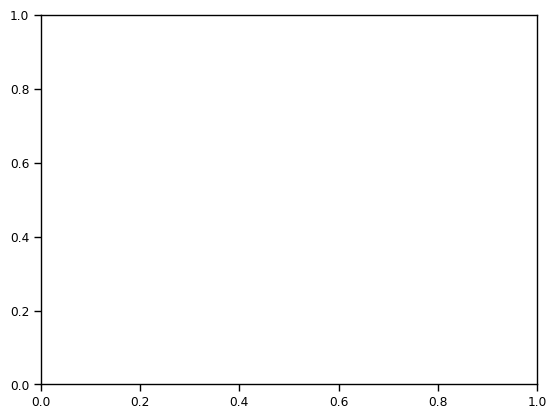

In [542]:
plot_ENST_trace("ENST00000348066", start, end)

In [543]:
cc_names

,uniprotID,Gene,start,end,pMVS #,Gene Name,ENST,len
10,P43354,NR4A2,584,598,383,NR4A2_AD2,ENST00000339562,15
2,P11308,ERG,433,479,400,ERG_AD1,ENST00000288319,47
14,P78337,PITX1,234,283,409,PITX1_AD,ENST00000265340,50
8,O95096,NKX2-2,220,273,381,NKX2-2_AD,ENST00000377142,54
12,Q02548,PAX5,304,358,410,PAX5_AD,ENST00000358127,55
4,Q13422,IKZF1,284,365,402,IKZF1_AD,ENST00000331340,82
9,P43354,NR4A2,1,91,382,NR4A2_AD1,ENST00000339562,91
1,O94983,CAMTA2,472,581,405,CAMTA2_AD2,ENST00000348066,110
5,O14770,MEIS2,340,477,377,MEIS2_AD,ENST00000561208,138
3,P11308,ERG,118,261,406,ERG_AD2,ENST00000288319,144


In [544]:
import random
random_number = random.randint(-10, 10)
random_number

-2

In [545]:
# TRy for CAMTA 2 AD 1

def plot_vars_and_zoonomia(AD):
    AD_pt_vars = pt_vars[pt_vars["Gene Name"]  == AD]
    AD_gnomad = gnomad[gnomad["Gene Name"] == AD]
    
     # Create the top plot (original histogram)
    min_pos = cc_names[cc_names["Gene Name"] == AD]["start"].iloc[0]
    max_pos =cc_names[cc_names["Gene Name"] == AD]["end"].iloc[0]
    
    # Create a figure with two subplots (top and bottom) sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8.5 * (max_pos - min_pos) / 150, 11/15), sharex=True, dpi = 300)
    
    
    sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
                 x="pos", kde=False, edgecolor = "none", palette = color_palette,
                 hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)
    
    # Add title to the top plot
    ax1.set_ylabel(AD, rotation=0, labelpad=50, fontsize=10)  # Gene name on the left
    sns.despine(ax=ax1)
    
    sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = color_palette["gnomAD"], edgecolor = "none", label = "gnomAD",
                 element="bars", bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)
    
    # ax1_ymin, ax_1ymax = ax1.get_ylim()
    # ax2_ymin, ax_2ymax = ax2.get_ylim()
    #ymin, ymax = min(ax1_ymin, ax2_ymin), max(ax_1ymax, ax_2ymax)
    ymin, ymax = 0, 10
    
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    
    # Invert the y-axis for the bottom plot
    ax2.invert_yaxis()
    ax2.set_ylabel("        Count")
    ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
    ax2.set_xlim(min_pos, max_pos)
    ax2.set_xlabel("")
    

    ENST = cc_names[cc_names["Gene Name"] == AD]["ENST"].iloc[0]

    
    # x = np.arange(285, 465)
    # y = np.array([random.randint(-12, 10) for _ in x])
    x, y = plot_ENST_trace(ENST, min_pos, max_pos)
    
    # For positive values
    extreme = max(abs(y))
    print(extreme)
    
    ax1_right = ax1.twinx()
    sns.lineplot(x = x, y = y, ax = ax1_right, alpha = 0.5)
    ax1_right.set_ylim(0, extreme)
    
    #For negative values
    ax2_right = ax2.twinx()
    sns.lineplot(x = x, y = -1 * y, ax = ax2_right, alpha = 0.5)
    ax2_right.set_ylim(extreme, 0)
    
    # Add title to the bottom plot
    sns.despine()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

8.172453023057065
12.311
8.805
8.84
8.899
14.654
8.88
7.993243068491486
8.87
12.869
7.887055557977139
8.901
7.635300541336368
9.348
7.632619411254537


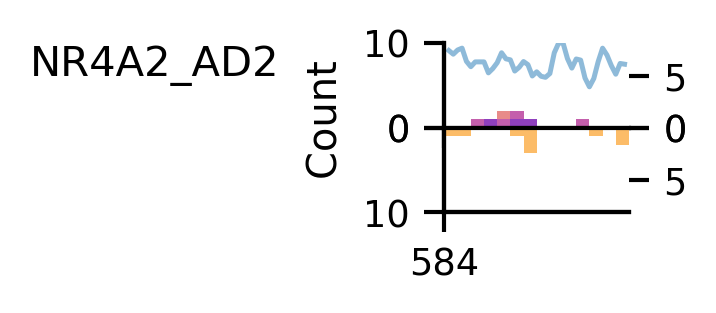

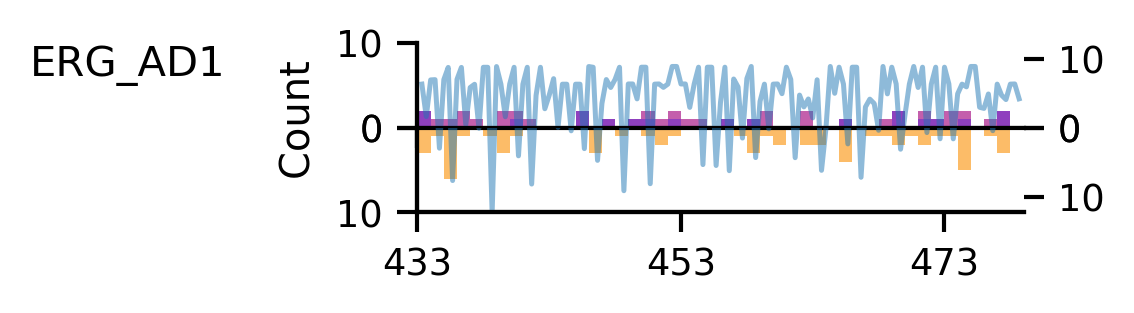

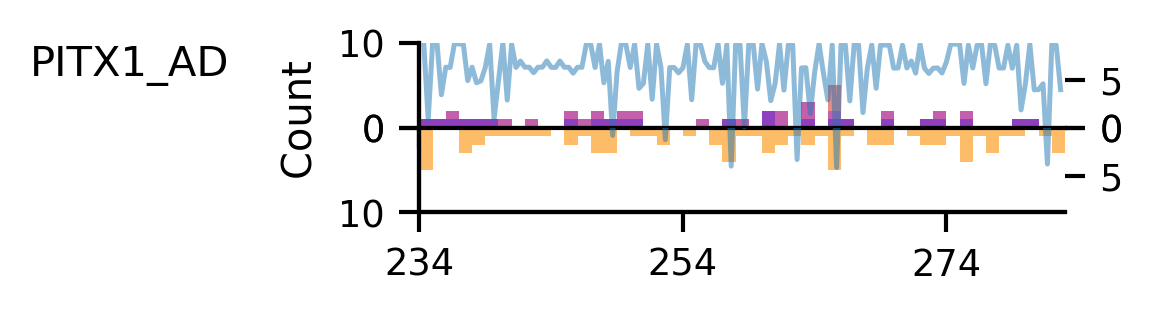

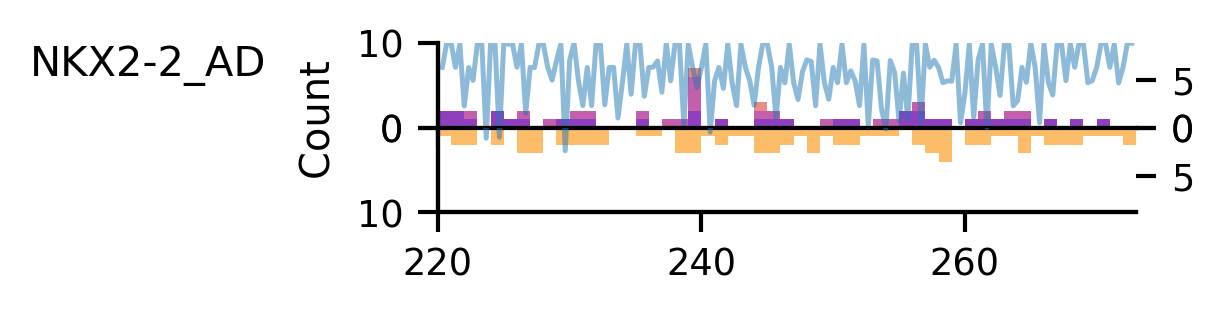

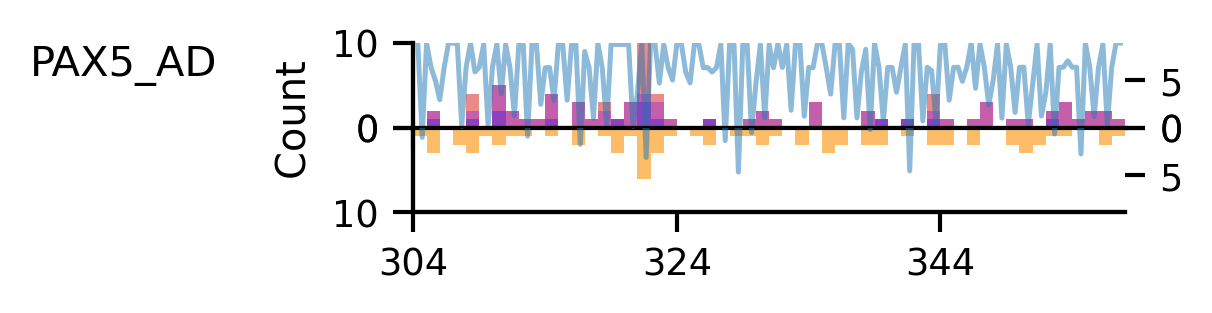

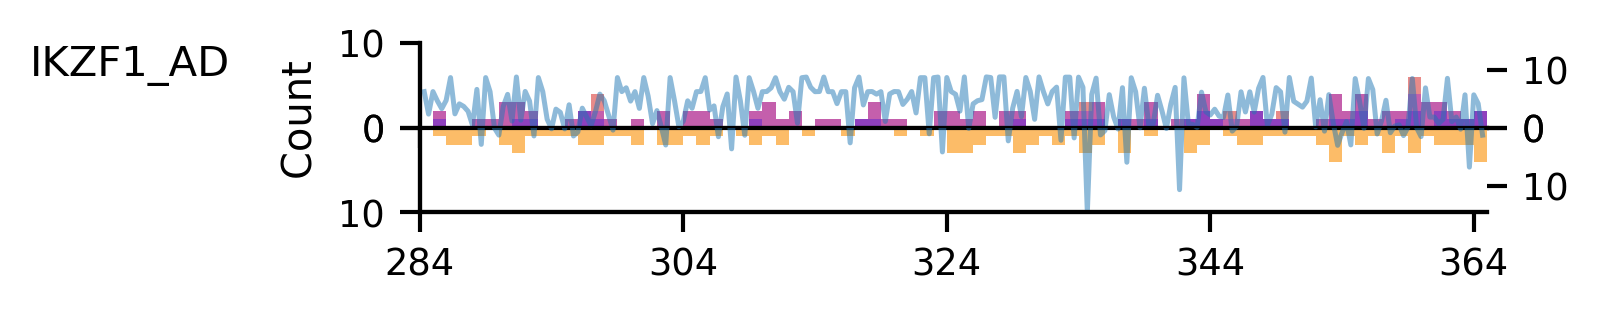

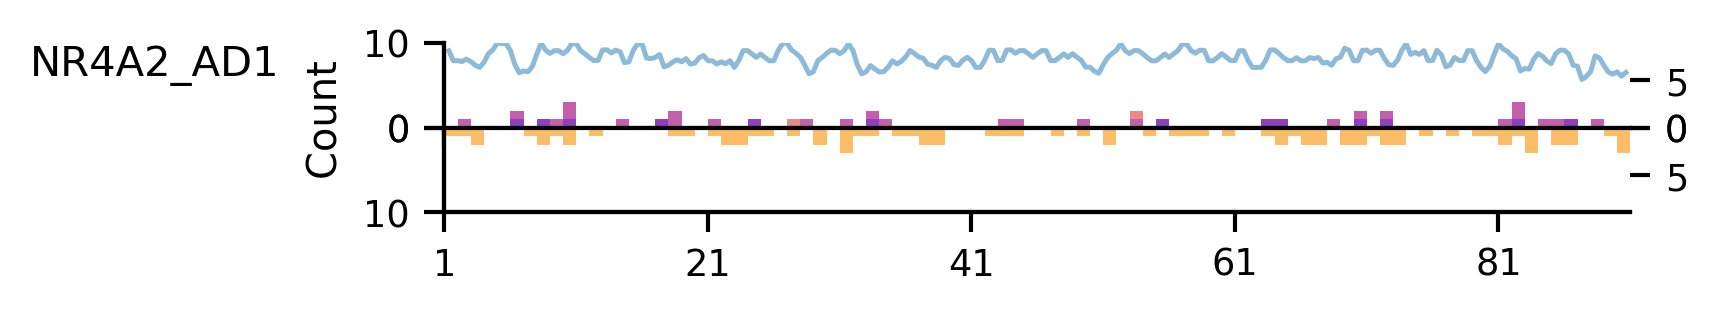

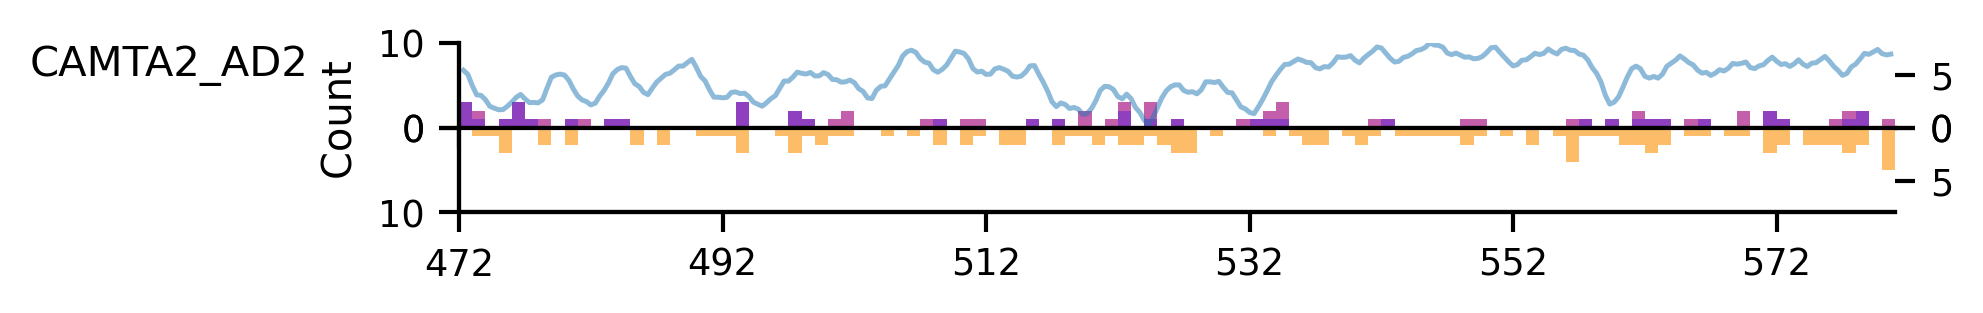

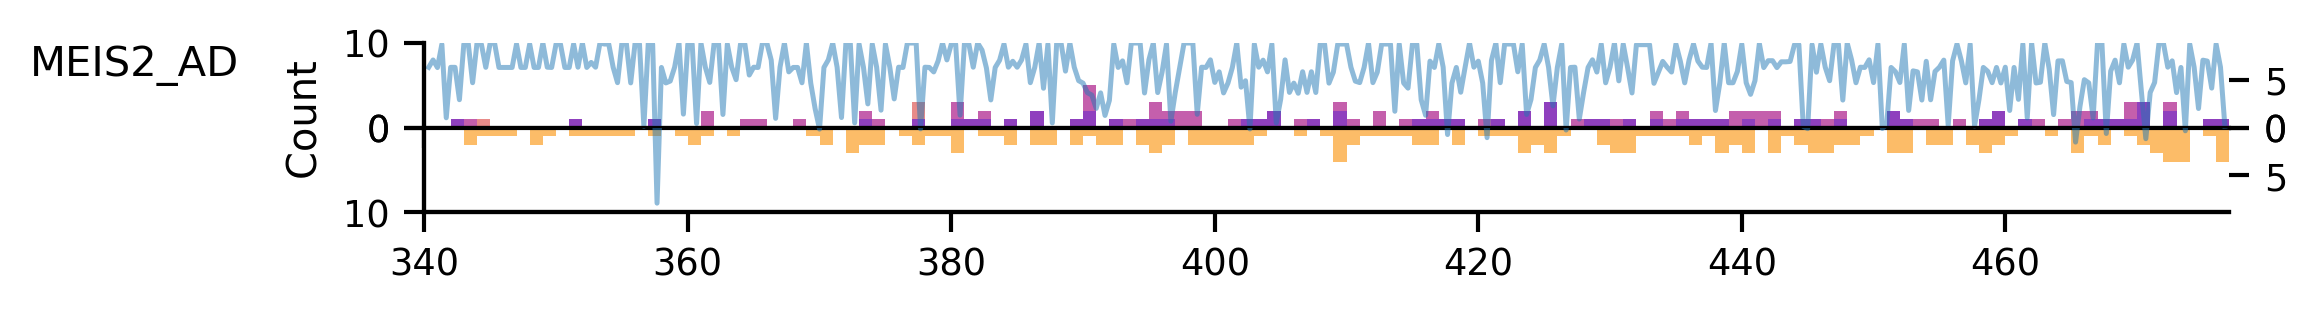

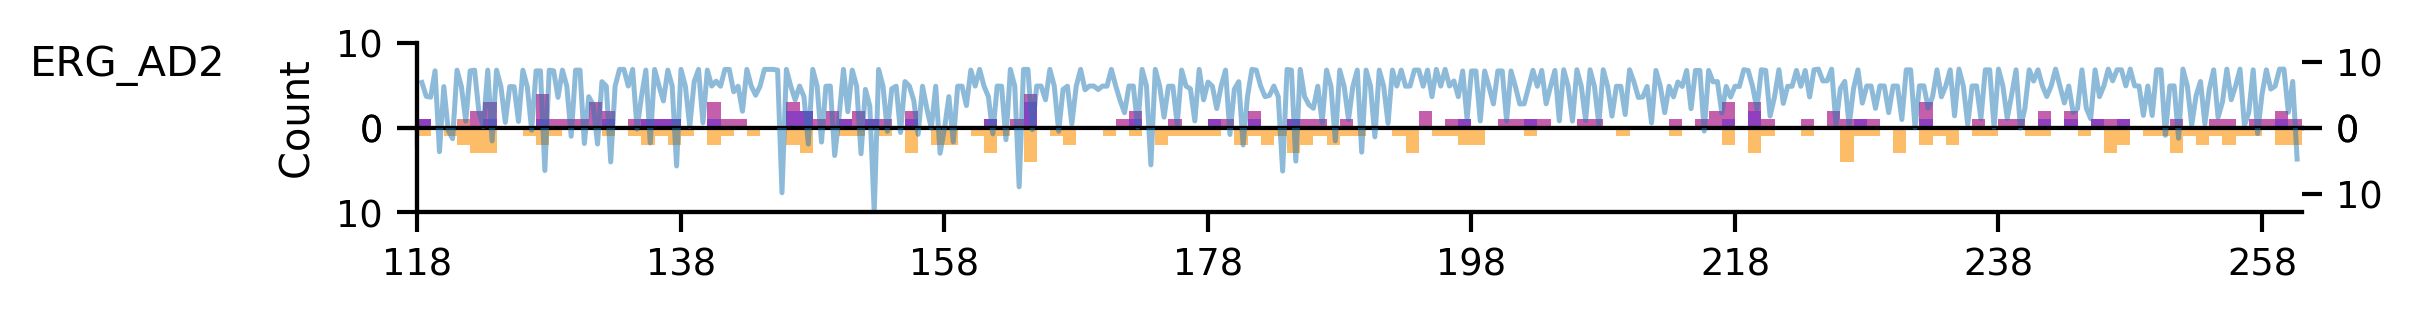

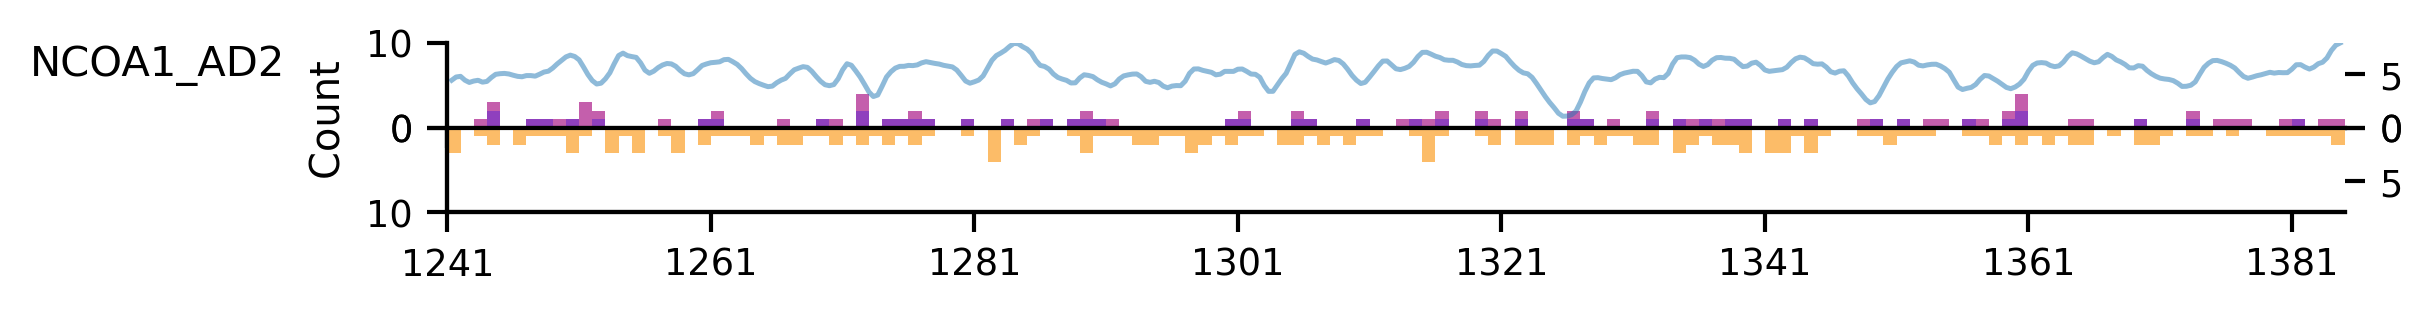

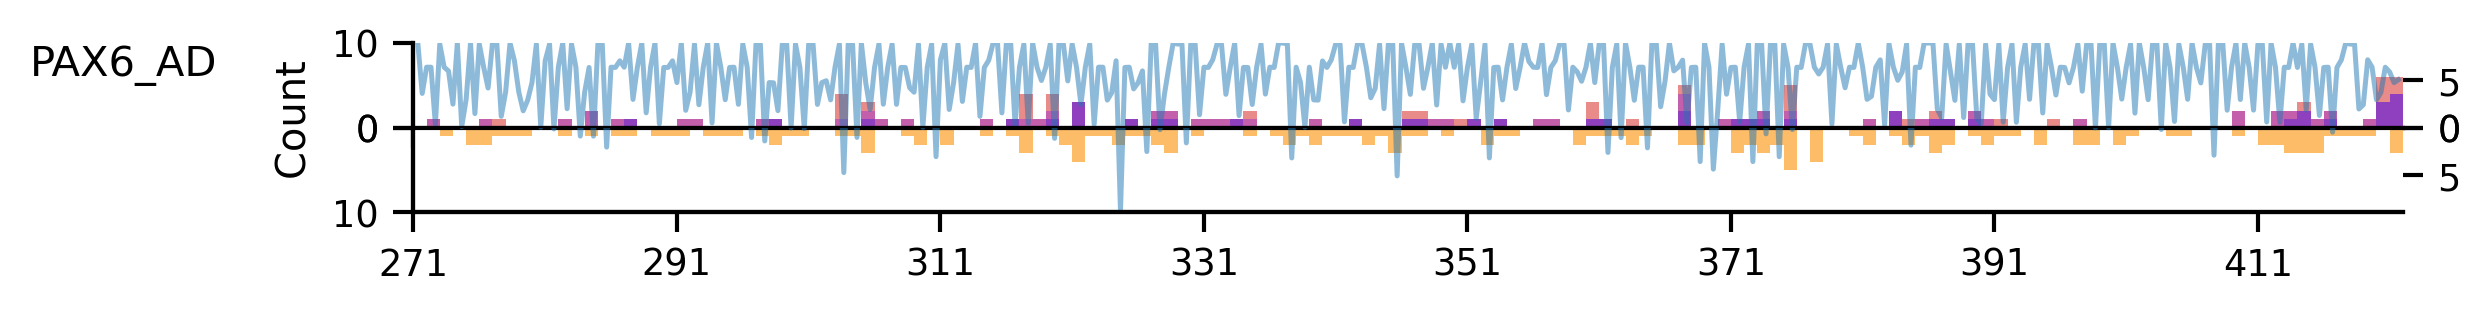

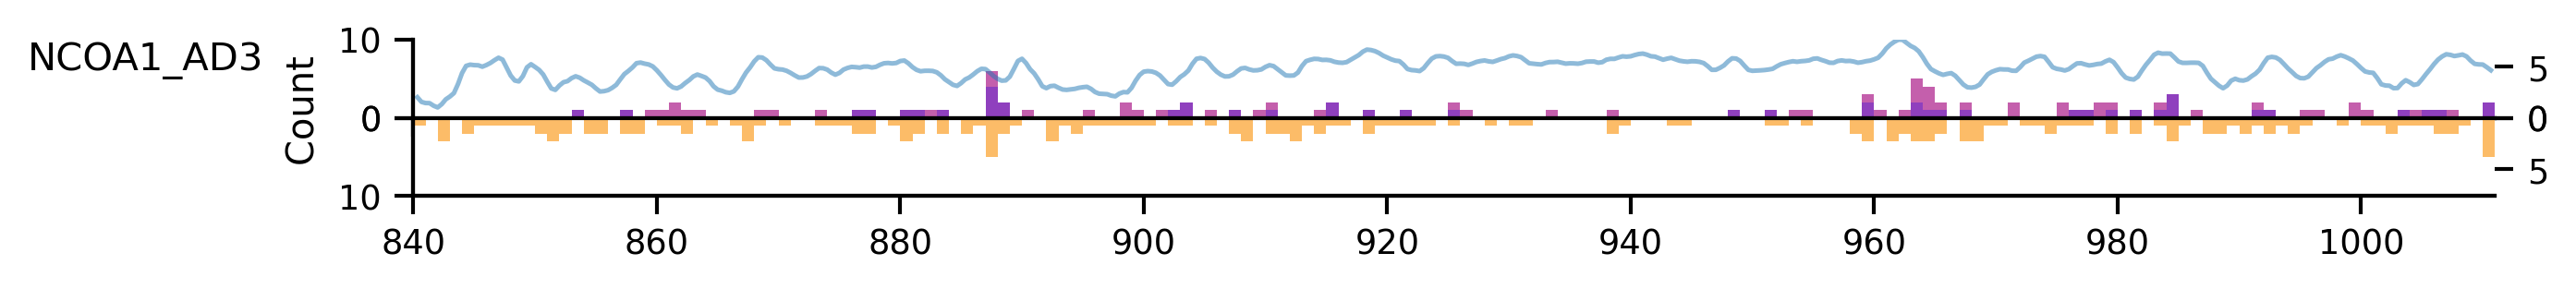

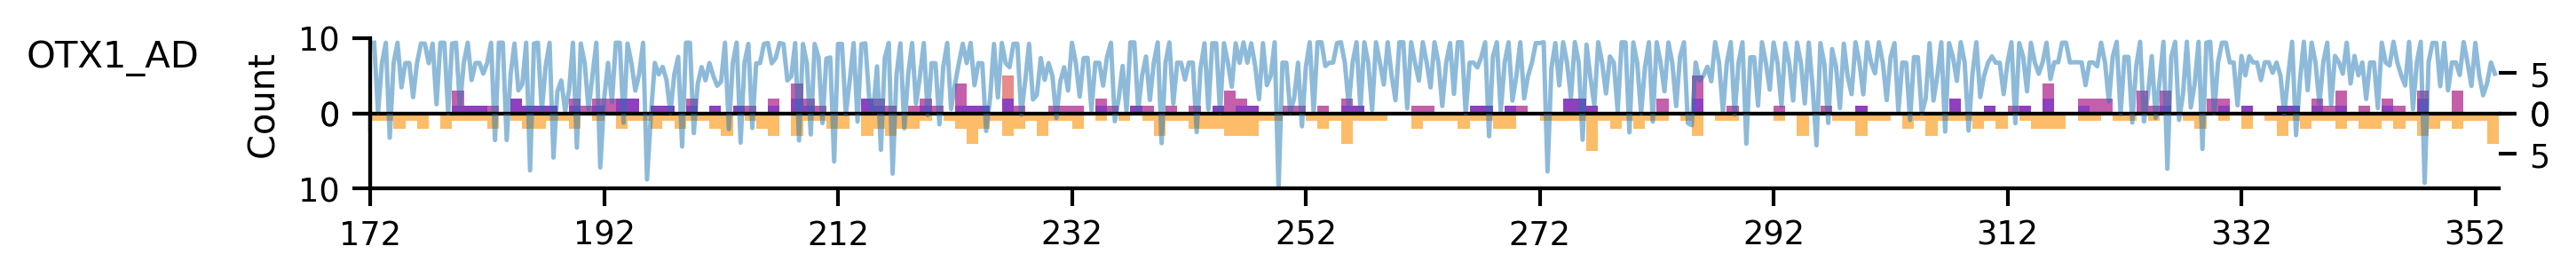

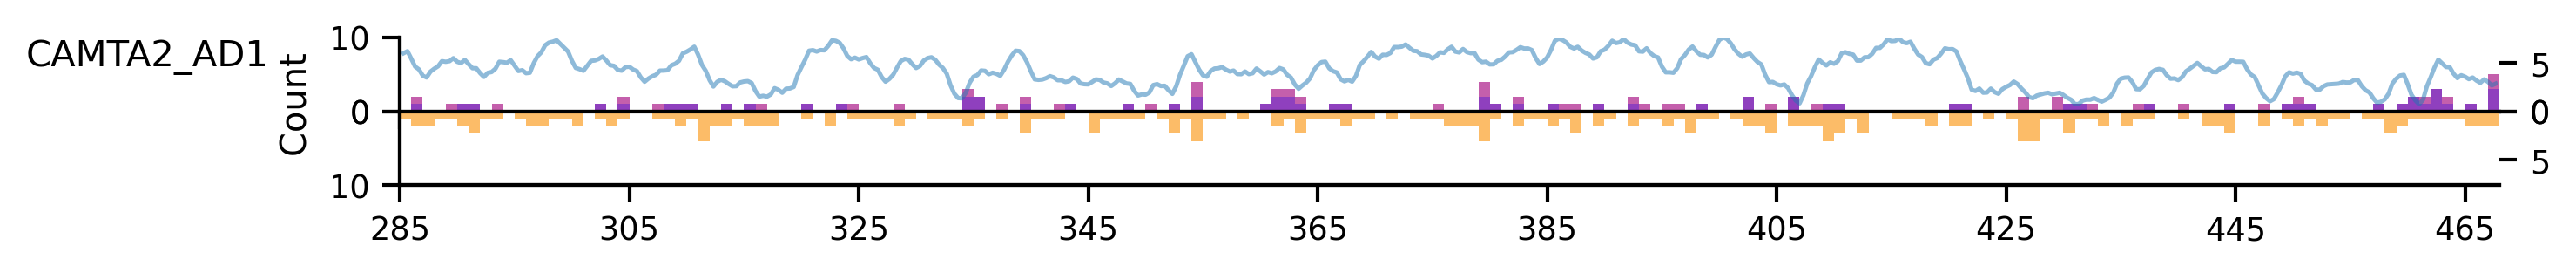

In [546]:

for AD in cc_names["Gene Name"]:
    plot_vars_and_zoonomia(AD)


In [ ]:



from matplotlib.backends.backend_pdf import PdfPages

sns.set_context('paper')

def plot_one_AD_track(AD):
    AD_pt_vars = pt_vars[pt_vars["Gene Name"]  == AD]
    AD_gnomad = gnomad[gnomad["Gene Name"] == AD]

     # Create the top plot (original histogram)
    min_pos = cc_names[cc_names["Gene Name"] == AD]["start"].iloc[0]
    max_pos =cc_names[cc_names["Gene Name"] == AD]["end"].iloc[0]
    
    # Create a figure with two subplots (top and bottom) sharing the x-axis
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8.5 * (max_pos - min_pos) / 150, 11/15), sharex=True, dpi = 300)
    

    sns.histplot(data=AD_pt_vars, stat="count", multiple="stack",
                 x="pos", kde=False, edgecolor = "none", palette = color_palette,
                 hue="list", element="bars", legend=False, bins=np.arange(min_pos, max_pos + 1, 1), ax=ax1)
    
    # Add title to the top plot
    ax1.set_ylabel(AD, rotation=0, labelpad=50, fontsize=10)  # Gene name on the left
    sns.despine(ax=ax1)
    
    sns.histplot(data=AD_gnomad, stat="count", 
                 x="pos", kde=False, color = color_palette["gnomAD"], edgecolor = "none", label = "gnomAD",
                 element="bars", bins=np.arange(min_pos, max_pos + 1, 1), ax=ax2)

    # ax1_ymin, ax_1ymax = ax1.get_ylim()
    # ax2_ymin, ax_2ymax = ax2.get_ylim()
    #ymin, ymax = min(ax1_ymin, ax2_ymin), max(ax_1ymax, ax_2ymax)
    ymin, ymax = 0, 10
    
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    
    # Invert the y-axis for the bottom plot
    ax2.invert_yaxis()
    ax2.set_ylabel("        Count")
    ax2.set_xticks(np.arange(min_pos, max_pos + 1, 20))
    ax2.set_xlim(min_pos, max_pos)
    ax2.set_xlabel("")

    
    # Add title to the bottom plot
    sns.despine()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

    

cc_names = cc_names.sort_values(by = "len", ascending = True)

# with PdfPages('AD_tracks.pdf') as pdf:

for AD in cc_names["Gene Name"]:
    plot_one_AD_track(AD)

# Manually create the legend
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["SPARK"], markersize=10, label="SPARK"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["COSMIC"], markersize=10, label="COSMIC"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["ClinVar"], markersize=10, label="ClinVar"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette["gnomAD"], markersize=10, label="gnomAD")
]

# Add the legend to the plot
plt.legend(handles=legend_labels, loc = (1.05 ,-0.5))

# Show the plot
plt.show()

In [ ]:
num_plots = 15
fig, axes = plt.subplots(nrows=num_plots, figsize=(10, num_plots * 3), sharex=True)

i = 0
for AD in cc_names["Gene Name"]:
    ax - 

In [137]:
list(enumerate(cc_names["Gene Name"]))

[(0, 'NR4A2_AD2'),
 (1, 'ERG_AD1'),
 (2, 'PITX1_AD'),
 (3, 'NKX2-2_AD'),
 (4, 'PAX5_AD'),
 (5, 'IKZF1_AD'),
 (6, 'NR4A2_AD1'),
 (7, 'CAMTA2_AD2'),
 (8, 'MEIS2_AD'),
 (9, 'ERG_AD2'),
 (10, 'NCOA1_AD2'),
 (11, 'PAX6_AD'),
 (12, 'NCOA1_AD3'),
 (13, 'OTX1_AD'),
 (14, 'CAMTA2_AD1')]

In [12]:
concat_vars = pd.concat([clinvar, cosmic, pt_vars, gnomad])
all_muts = concat_vars[["Gene Name", "Mutant Sequence", "Protein Change"]]#.drop_duplicates()
all_muts

,Gene Name,Mutant Sequence,Protein Change
0,NKX2-2_AD,AQDLAAATFQAGIPFSAYSAQSLQYMQYNAQYSSASTPQYPTAHPL...,p.His244Tyr
1,NKX2-2_AD,AQDLAAATFQAGIPFSAYSVQSLQHMQYNAQYSSASTPQYPTAHPL...,p.Ala239Val
2,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Ser
3,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Arg
4,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Cys
...,...,...,...
1934,PAX5_AD,GRDSASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Leu307Ser
1935,PAX5_AD,GPDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Arg305Pro
1936,PAX5_AD,GHDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Arg305His
1937,PAX5_AD,GCDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Arg305Cys


In [13]:
#all_muts["am_bottom_10"] = all_muts["Mutant Sequence"].isin(am_bottom_10["Mutant Sequence"]).astype(int)
#all_muts["am_top_10"] = all_muts["Mutant Sequence"].isin(am_top_10["Mutant Sequence"]).astype(int)
all_muts["clinvar"] = all_muts["Mutant Sequence"].isin(clinvar["Mutant Sequence"]).astype(int)
all_muts["cosmic"] = all_muts["Mutant Sequence"].isin(cosmic["Mutant Sequence"]).astype(int)
all_muts["pt_vars"] = all_muts["Mutant Sequence"].isin(pt_vars["Mutant Sequence"]).astype(int)
all_muts["gnomad"] = all_muts["Mutant Sequence"].isin(gnomad["Mutant Sequence"]).astype(int)
all_muts

,Gene Name,Mutant Sequence,Protein Change,clinvar,cosmic,pt_vars,gnomad
0,NKX2-2_AD,AQDLAAATFQAGIPFSAYSAQSLQYMQYNAQYSSASTPQYPTAHPL...,p.His244Tyr,1,1,1,1
1,NKX2-2_AD,AQDLAAATFQAGIPFSAYSVQSLQHMQYNAQYSSASTPQYPTAHPL...,p.Ala239Val,1,1,1,1
2,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Ser,1,0,1,1
3,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Arg,1,0,1,1
4,OTX1_AD,AASSIWSPASISPGSAPASVSVPEPLAAPSNTSCMQRSVAAGAATA...,p.Gly226Cys,1,0,1,1
...,...,...,...,...,...,...,...
1934,PAX5_AD,GRDSASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Leu307Ser,0,0,0,1
1935,PAX5_AD,GPDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Arg305Pro,0,0,0,1
1936,PAX5_AD,GHDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Arg305His,0,1,1,1
1937,PAX5_AD,GCDLASTTLPGYPPHVPPAGQGSYSAPTLTGMVPGSEFSGSPYSHP...,p.Arg305Cys,0,0,0,1
